# Сборный Проект - 2. HR-аналитика компании «Работа с заботой».

## О проекте

__Заказчик исследования__: компания «Работа с заботой» (HR-отдел).

__Главная цель исследования__:  разработать решение, которое поможет в оптимизации управления персоналом. 

__Задачи исследования__:
- предсказание уровня удовлетворённости сотрудника;
- предсказание увольнения сотрудника из компании.

__Данные для исследования__:

- Тренировочные выборки:
    - _train_features_satisfaction.csv_ 
    - _train_features_quit.csv_
- Входные признаки тестовой выборки:
    - _test_features.csv_
- Целевые признаки тестовых выборок:    
    - _test_target_satisfaction.csv_ 
    - _test_target_quit.csv_
    
__План проведения исследования__:
1. Решение задачи "предсказание уровня удовлетворённости сотрудника":
    * Загрузка данных
    * Предобработка данных
    * Исследовательский анализ данных
    * Подготовка данных
    * Корреляционный анализ данных
    * Обучение моделей
    * Выбор лучшей модели
2. Решение задачи "предсказание увольнения сотрудника из компании":
    * Загрузка данных
    * Предобработка данных
    * Исследовательский анализ данных
    * Добавление нового входного признака
    * Корреляционный анализ данных
    * Подготовка данных
    * Обучение моделей
    * Выбор лучшей модели
3. Общий вывод.

## Подготовка к исследованию

In [ ]:
#!pip install -q scikit-learn==1.1.3 

In [ ]:
#!pip install -q phik

In [ ]:
#!pip install -q shap 

In [ ]:
#!pip install -q matplotlib==3.7.1

In [ ]:
# импортирование библиотек и функций
import itertools
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder,
                                   OrdinalEncoder, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

import shap

# настройки
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_colwidth', None)

# константы
# для однотипного отображения графиков
TITLE_SIZE = 18
LABEL_SIZE = 16
# для использования при работе с моделями
RANDOM_STATE = 42

## Предсказание уровня удовлетворённости сотрудника

Нам нужно решить задачу регрессии, в которой целевой признак "job_satisfaction_rate", с использованием обучения с учителем. 

### Загрузка данных

In [ ]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_features_satisfaction.csv')

In [ ]:
test_features = pd.read_csv('/datasets/test_features.csv')

In [ ]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_satisfaction.csv')

In [11]:
def get_head_and_info(dataset):
    """
    Выводит первые 5 строк набора данных dataset
    и общую информацию о нем (через метод info()).
    """
    display(dataset.head())
    dataset.info()

In [12]:
get_head_and_info(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Датасет train_job_satisfaction_rate содержит 4000 записей, данные соответствуют описанию. Есть небольшое количество пропусков в столбцах `dept` и `level`. Названия столбцов соответствуют змеиному регистру, типы данных определены верно.

In [13]:
get_head_and_info(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Датасет test_features содержит 2000 записей, данные соответствуют описанию. Есть небольшое количество пропусков в столбцах `dept` и `level`. Названия столбцов соответствуют змеиному регистру, типы данных определены верно.

In [14]:
get_head_and_info(test_target_job_satisfaction_rate)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датасет test_target_job_satisfaction_rate содержит 2000 записей, данные соответствуют описанию. Названия столбцов соответствуют змеиному регистру, типы данных определены верно, пропусков нет.

__Выводы__:
- загрузили данные для работы, изучили первые 5 строк и общую информацию о наборах данных;
- данные соответствуют описанию, названия столбцов соответствуют змеиному регистру, типы данных определены верно;
- датасет train_job_satisfaction_rate содержит 4000 записей, есть небольшое количество пропусков в столбцах `dept` и `level`;
- датасет test_features содержит 2000 записей, есть небольшое количество пропусков в столбцах `dept` и `level`;
- датасет test_target_job_satisfaction_rate содержит 2000 записей, пропусков нет.

### Предобработка данных

Определим количество пропусков в train_job_satisfaction_rate.

In [15]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Отметим, что пропусков в целевом признаке нет. Количество пропущенных значений незначительно. 

Определим, какие типы признаков у нас есть.

__Входные признаки__

Номинальные категориальные:
- dept
- last_year_promo
- last_year_violations

Ранговые:
- level
- workload

Численные:
- employment_years
- salary
- supervisor_evaluation

Признак id не оказывает влияния на таргет, его не учитываем.

__Целевой признак__ (численный)
- job_satisfaction_rate

В соответствии с этим, создадим списки с разными типами признаков.

In [16]:
# создадим списки с названиями признаков
all_columns = train_job_satisfaction_rate.columns.tolist()
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = train_job_satisfaction_rate.drop(
    columns=['id', 'job_satisfaction_rate']).select_dtypes(include='number').columns.tolist()

Пропуски для категориальных и ранговых переменных будем заполнять модой в пайплайне для подготовки данных с помощью SimpleImputer на этапе работы с моделями. 

Теперь проверим наличие дубликатов в данных (полных, а также по значению id).

In [17]:
train_job_satisfaction_rate.duplicated().sum()

0

In [18]:
train_job_satisfaction_rate.duplicated(subset=['id']).sum()

0

Дубликатов нет. Взглянем на уникальные значения категориальных признаков.

In [19]:
for column in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    print(f'Значения в столбце {column} : {train_job_satisfaction_rate[column].unique()}')

Значения в столбце dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Значения в столбце level : ['junior' 'middle' 'sinior' nan]
Значения в столбце workload : ['medium' 'high' 'low']
Значения в столбце last_year_promo : ['no' 'yes']
Значения в столбце last_year_violations : ['no' 'yes']


Все в порядке, ошибок не обнаружено. Nan значения будут заполнены в пайплайне.

__Выводы__:
- определили, что пропуски для категориальных и ранговых переменных будем заполнять модой в пайплайне предобработки данных с помощью SimpleImputer;
- явных дубликатов, а также дубликатов по id нет;
- категориальные значения записаны без ошибок.

### Исследовательский анализ данных

Определим функции, которые помогут нам в проведении EDA.

In [20]:
def analyze_categorical_data(data, columns):
    """
    Функция выводит информацию о распределении значений категориальных признаков, 
    а также строит столбчатую или круговую диаграмму
    в зависимости от количества уникальных значений в столбце.

    Параметры:
    data (DataFrame) : датасет
    columns (dict) : словарь, где ключи - названия колонок, значения - их описания
    """
    for column, name in columns.items():
        # посмотрим на значения столбца
        print(f'___{column}___')
       
        agg_table = (
            data.groupby(column).agg(
                count = (column, 'count'),
                percentage = (column, lambda x: 100 * x.size / data.shape[0]),
                job_satisfaction_rate_median = ('job_satisfaction_rate', 'median'))
            .sort_values(by='count', ascending=False)
        )
        print(agg_table)
        
        # построим график
        if (agg_table.shape[0] > 2):
            fig, ax = plt.subplots(figsize=(15, 5))
            agg_table['count'].sort_values().plot(
                kind='barh', ax=ax, rot=0, legend=False, color='skyblue')
            ax.set_title(f'Частота значений для столбца "{column}"', fontsize=TITLE_SIZE)
            ax.set_ylabel(name, fontsize=LABEL_SIZE)
            ax.set_xlabel('Частота', fontsize=LABEL_SIZE)
            
            for bar in ax.patches:
                ax.annotate(f'{int(bar.get_width())}', 
                        xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                        xytext=(5, 0), 
                        textcoords="offset points",
                        ha='left', va='center')
            plt.show()
            
        else:
            fig, ax = plt.subplots(figsize=(8, 8))
            agg_table['count'].plot.pie(
                ax=ax,
                legend=True,
                ylabel='',
                fontsize=14,
                autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, round(p * agg_table['count'].sum() / 100))
                )
            ax.set_title(name, fontsize=TITLE_SIZE)
            plt.show()

In [21]:
def analyze_discrete_data(data, column, title):
    """
    Функция помогает при проведении статистического анализа дискретных численных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.

    Выводит для колонки:
    - описание данных
    - график частот
    - диаграмму размаха
    """
     
    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())
        
    # Создаем фигуру и оси
    fig, ax = plt.subplots(2, 1, figsize=(17, 12))

    # График частот
    sns.countplot(x=data[column], ax=ax[0], palette='Blues')
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(False)
    # Добавление значений на столбцах
    for p in ax[0].patches:
        ax[0].annotate(f'{p.get_height():.0f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       fontsize=12, color='black',
                       xytext=(0, 5), textcoords='offset points')

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [22]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - описание данных
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """
     
    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())
    
    median = data[column].median()
    mean = data[column].mean()
        
    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)
    
    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Изучим категориальные переменные.

___dept___
            count  percentage  job_satisfaction_rate_median
dept                                                       
sales        1512       37.80                         0.570
technology    866       21.65                         0.550
purchasing    610       15.25                         0.585
marketing     550       13.75                         0.520
hr            456       11.40                         0.560


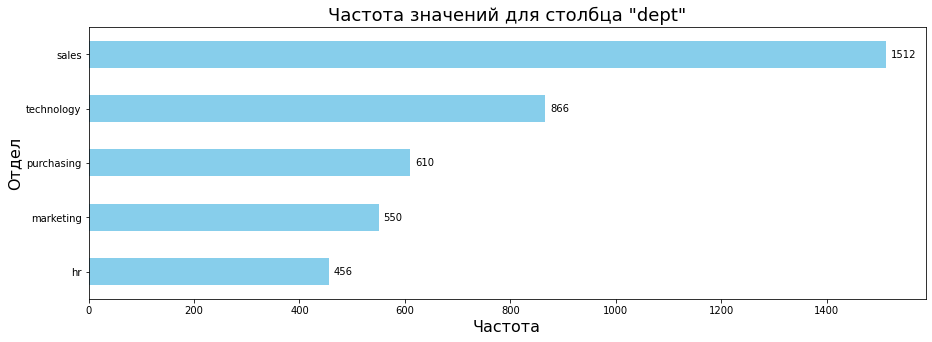

___last_year_promo___
                 count  percentage  job_satisfaction_rate_median
last_year_promo                                                 
no                3880        97.0                          0.55
yes                120         3.0                          0.70


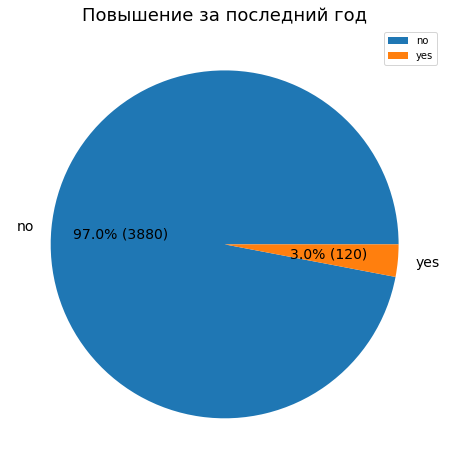

___last_year_violations___
                      count  percentage  job_satisfaction_rate_median
last_year_violations                                                 
no                     3441      86.025                           0.6
yes                     559      13.975                           0.3


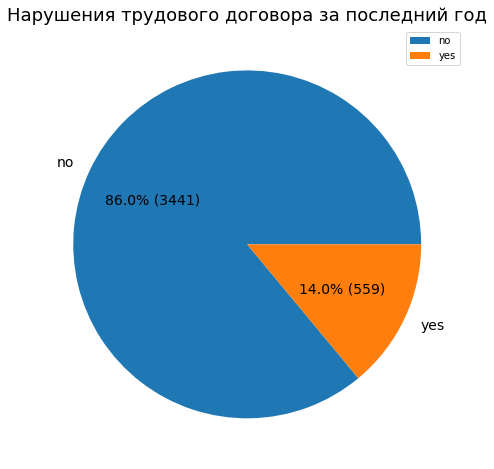

In [23]:
analyze_categorical_data(train_job_satisfaction_rate, 
                         {'dept':'Отдел',
                          'last_year_promo':'Повышение за последний год',
                          'last_year_violations':'Нарушения трудового договора за последний год'})

В данных присутствует информация о сотрудниках из 5 отделов: sales (37.8%), technology (21.65%), purchasing (15.25%), 
marketing (13.75%), hr (11.4%). Уровень удовлетворенности работой в отделах незначительно отличается: максимальное медианное значение 0.59 в отделе purchasing, минимальное - 0.52 в отделе marketing.

По данным нашей выборки только 3% сотрудников получили повышение за последний год. Медианное значение уровня удовлетворенности работой у таких сотрудников составляет 0.7, тогда как у тех, кто не получал повышение - 0.55.

14% сотрудников нарушали трудовой договор за последний год. Медианное значение уровня удовлетворенности работой у таких сотрудников в 2 раза ниже и составляет 0.3 против 0.6. 

Изучим ранговые переменные.

___level___
        count  percentage  job_satisfaction_rate_median
level                                                  
junior   1894       47.35                          0.55
middle   1744       43.60                          0.58
sinior    358        8.95                          0.54


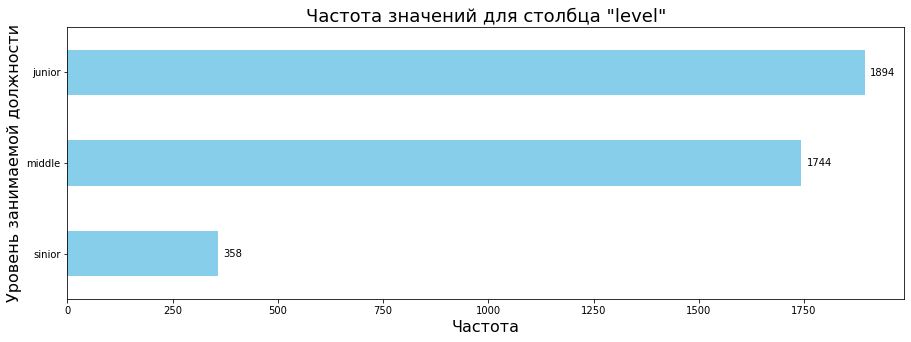

___workload___
          count  percentage  job_satisfaction_rate_median
workload                                                 
medium     2066       51.65                          0.54
low        1200       30.00                          0.58
high        734       18.35                          0.58


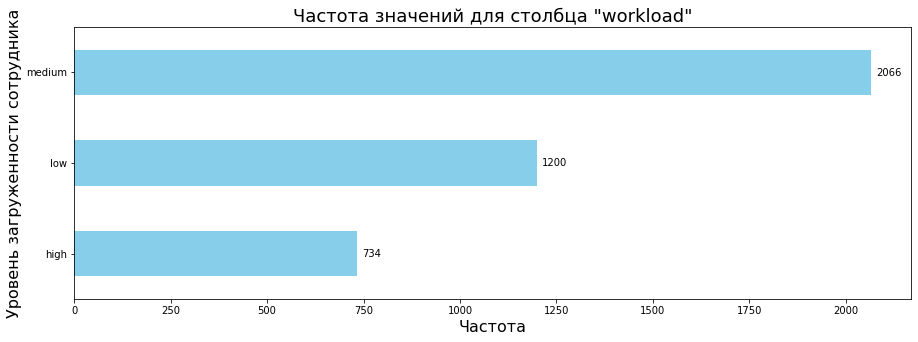

In [24]:
analyze_categorical_data(train_job_satisfaction_rate, 
                         {'level':'Уровень занимаемой должности',
                          'workload':'Уровень загруженности сотрудника'})

В датасете представлены данные о сотрудниках 3 уровней должностей: 'junior'(47.35%), 'middle'(43.6%), 'sinior'(8.95%). Наименьшее среди этих групп медианное значение уровня удовлетворенности работой наблюдается у сотрудников 'sinior'(0.54), наибольшее значение - у сотрудников 'middle'(0.58).

Выделяют три уровня загруженности сотрудников: 'low'(30%), 'medium'(51.65%), 'high'(18.35%). Медианное значение уровня удовлетворенности работой при загрузке 'low' и 'high'- 0.58, 'medium'- 0.54.

Теперь изучим численные признаки.

Длительность работы в компании (в годах)


count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

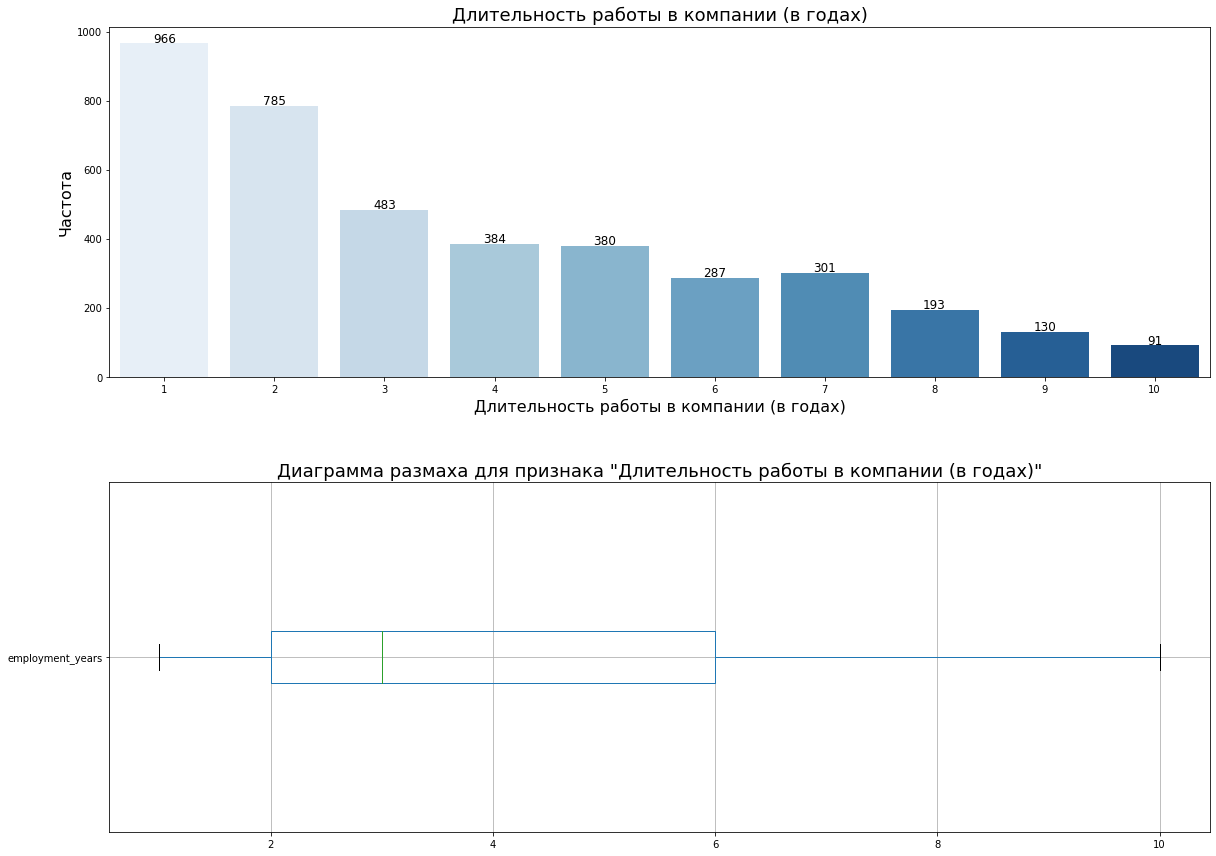

In [25]:
analyze_discrete_data(train_job_satisfaction_rate, 'employment_years',
                      'Длительность работы в компании (в годах)')

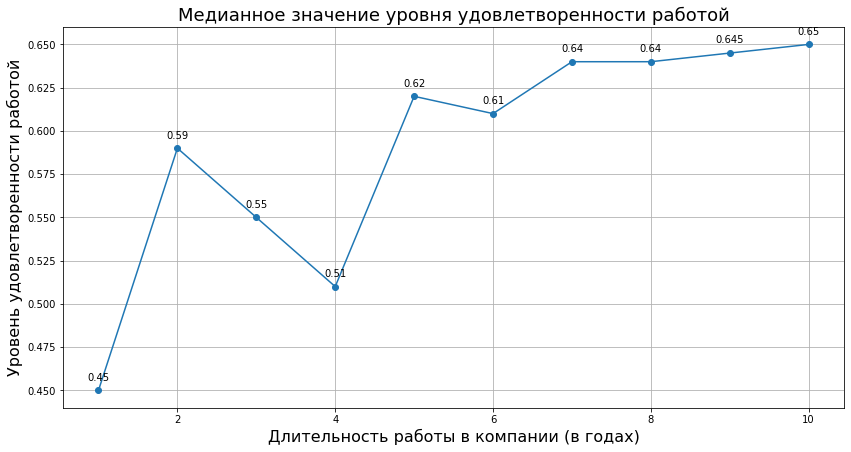

In [26]:
agg_data = (
    train_job_satisfaction_rate
    .groupby('employment_years')
    .agg(
        count=('job_satisfaction_rate', 'count'),
        job_satisfaction_rate_median=('job_satisfaction_rate','median')
    )
)
fig, ax = plt.subplots(figsize=(14, 7))
agg_data.plot(y='job_satisfaction_rate_median', ax=ax, style='o-', legend=False)
ax.set_title('Медианное значение уровня удовлетворенности работой', fontsize=TITLE_SIZE)
ax.set_xlabel('Длительность работы в компании (в годах)', fontsize=LABEL_SIZE)
ax.set_ylabel('Уровень удовлетворенности работой', fontsize=LABEL_SIZE)
ax.grid(True)
# Добавляем значения к каждой точке
for i, txt in enumerate(agg_data['job_satisfaction_rate_median']):
    ax.annotate(
        txt,
        (agg_data.index[i], agg_data['job_satisfaction_rate_median'].iloc[i]),
        textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


Признак "employment_years" имеет дискретную природу, принимает значения от 1 до 10. Медианное значение - 3, среднее больше медианного - 3.72. Стандартное отклонение - 2.54. Границы межквартильного размаха - от 2 до 6. Выбросов нет.
В целом можно сказать, что согласно предоставленным данным, наибольшие медианные значения уровня удовлетворенности работой наблюдаются у сотрудников, проработавших в компании от 7 лет.

Оценка качества работы сотрудника, которую дал руководитель


count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

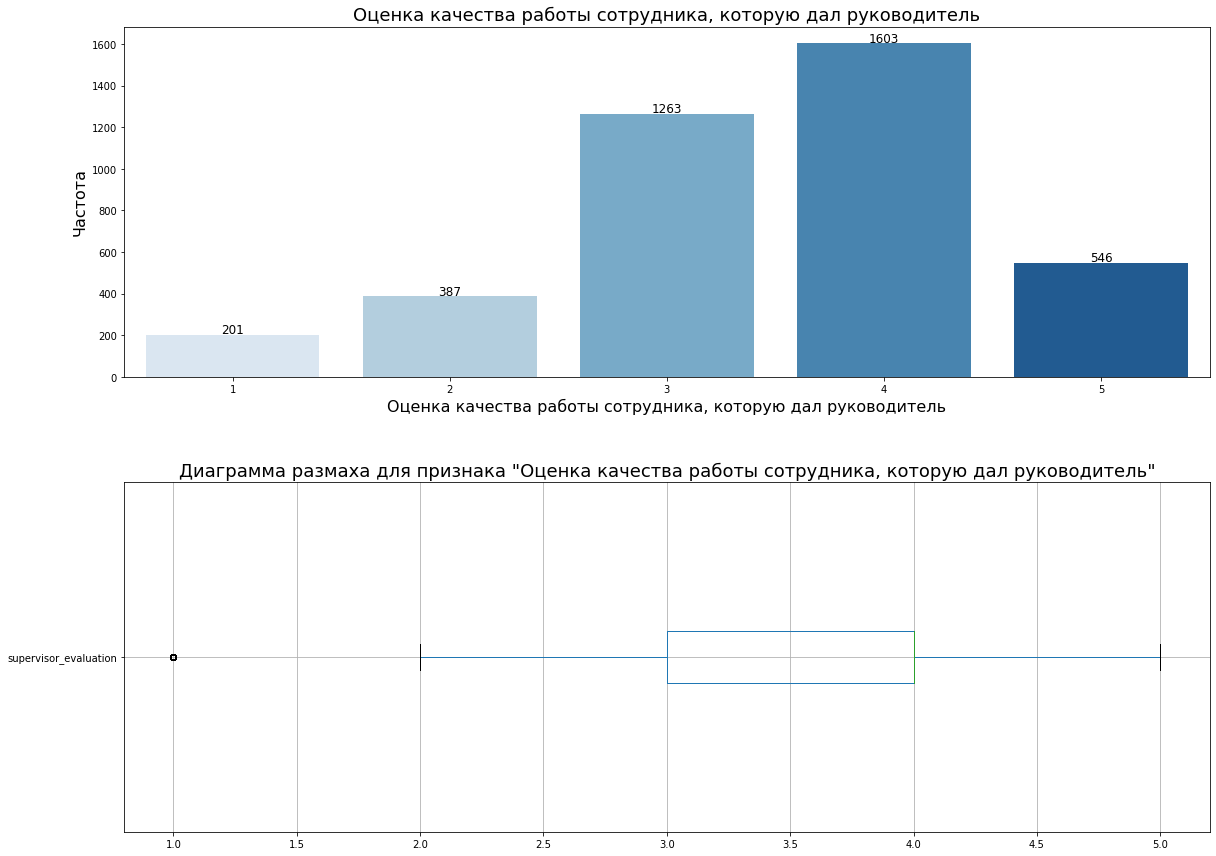

In [27]:
analyze_discrete_data(train_job_satisfaction_rate, 'supervisor_evaluation',
                      'Оценка качества работы сотрудника, которую дал руководитель')

In [28]:
(
    train_job_satisfaction_rate
    .groupby('supervisor_evaluation')
    .agg(
        count=('job_satisfaction_rate', 'count'),
        job_satisfaction_rate_median=('job_satisfaction_rate','median')
    )
)

,count,job_satisfaction_rate_median
supervisor_evaluation,,
1,201,0.31
2,387,0.33
3,1263,0.36
4,1603,0.70
5,546,0.70


Признак "supervisor_evaluation" имеет дискретную природу, принимает значения от 1 до 5. Медианное значение при этом - 4, среднее - 3.48. Стандартное отклонение - 1. Границы межквартильного размаха - от 3 до 4. Оценка 1 - нетипичная для нашего датасета, однако не является аномалией. Изучив предоставленные данные можно заметить, что при более высоких оценках качества работы работодателем наблюдается более высокое медианное значение уровня удовлетворенности работой сотрудника: 0.7 при оценках 4 и 5, 0.31-0.36 при оценках от 1 до 3.

Зарплата сотрудника


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

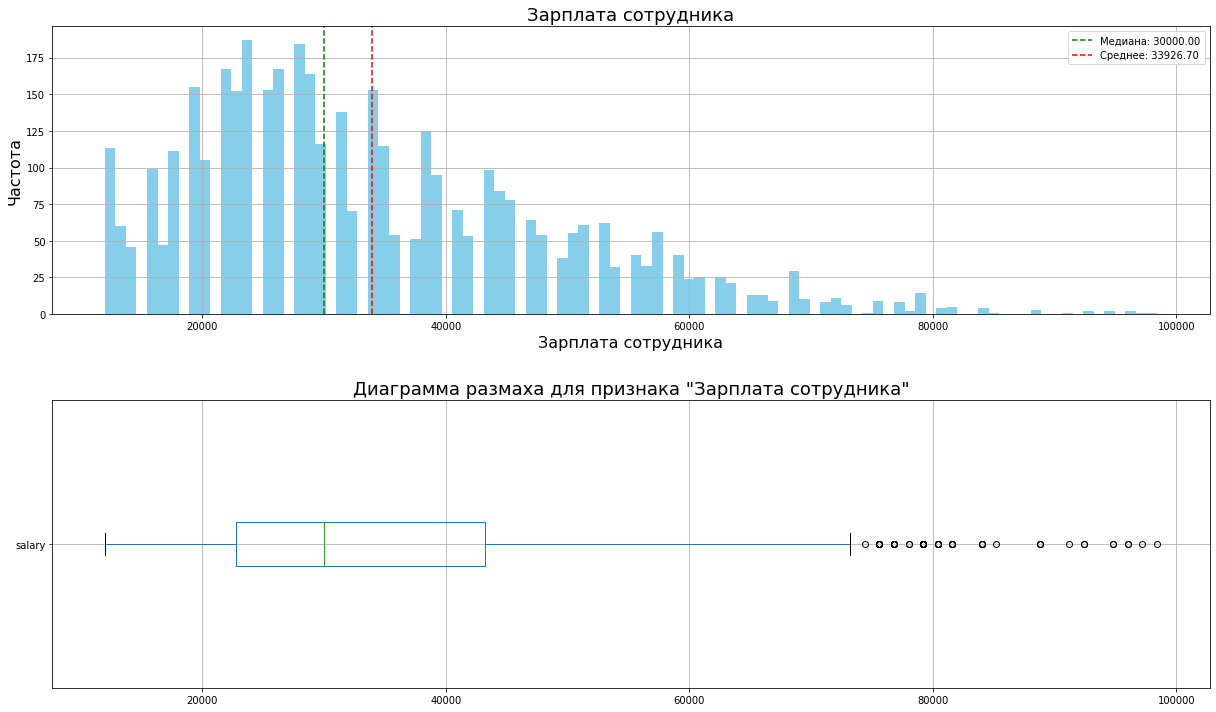

In [29]:
analyze_numerical_data(train_job_satisfaction_rate, 'salary',
                      'Зарплата сотрудника', bins_number=100)

In [30]:
# получим крайнее значение, которое не является выбросом
whishi = boxplot_stats(train_job_satisfaction_rate['salary'])[0]['whishi']
whishi

73200

In [31]:
train_job_satisfaction_rate[train_job_satisfaction_rate['salary'] > whishi]['level'].value_counts()

sinior    60
Name: level, dtype: int64

Значения признака "salary" распределены в диапазоне от 12000 до 98400. Медианное значение - 30000, среднее больше медианного - 33926.7. Стандартное отклонение - 14900.7. Границы межквартильного размаха - от 22800 до 43200. Часть наблюдений опредлена как выбросы (зарплата более 73200). Если изучить подробнее срез с высокой зарплатой, получим работников уровня "sinior" (высокий уровень - высокая зарплата, небольшая по численности группа). Значения не являются аномальными, оставим их.

Теперь изучим целевой признак job_satisfaction_rate.

Уровень удовлетворенности работой сотрудника


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

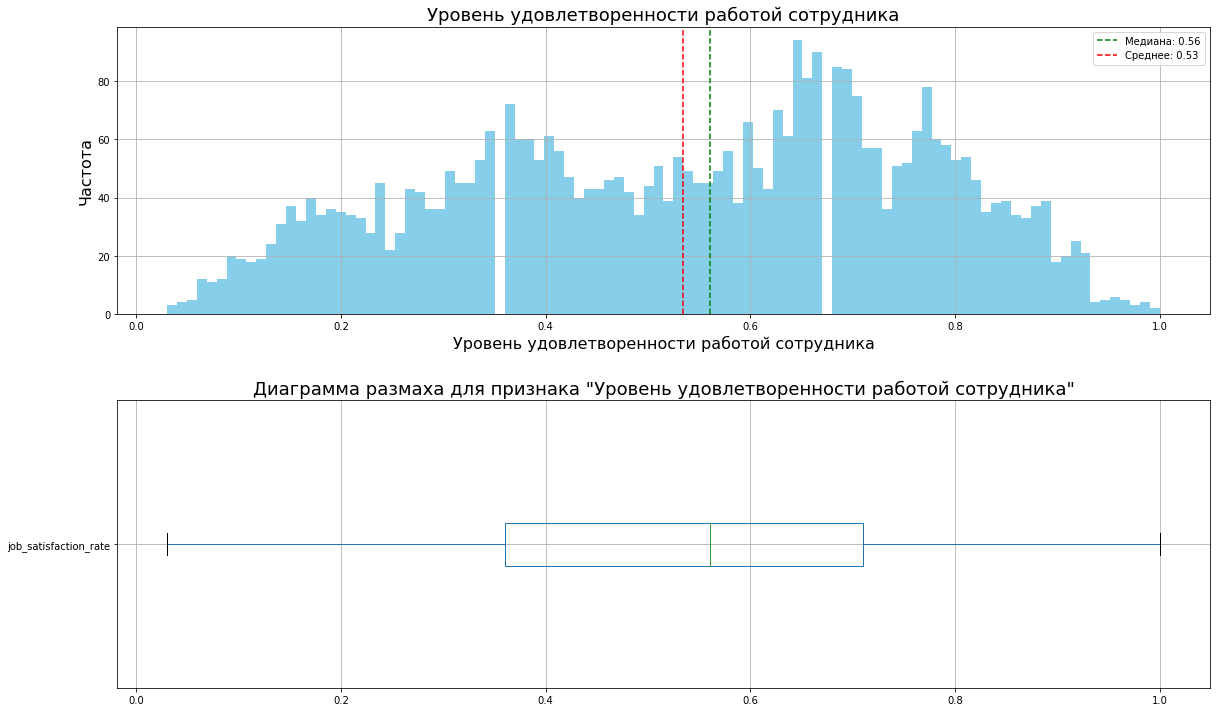

In [32]:
analyze_numerical_data(train_job_satisfaction_rate, 'job_satisfaction_rate',
                      'Уровень удовлетворенности работой сотрудника')

Значения целевого признака "job_satisfaction_rate" распределены в диапазоне от 0.03 до 1. Медианное значение - 0.56, среднее меньше медианного - 0.53. Стандартное отклонение - 0.23. Границы межквартильного размаха - от 0.36 до 0.71.  Можно говорить о широком распределении вокруг среднего значения.

Как мы уже определили выше, у нас есть номинальные категориальные признаки (dept, last_year_promo, last_year_violations), для них будем использовать OneHotEncoder, для ранговых признаков (level, workload) - OrdinalEncoder. Численные признаки (employment_years, salary, supervisor_evaluation) будем масштабировать. 

Взглянем также на __информацию о тестовом датасете__.

Уровень удовлетворенности работой сотрудника


count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

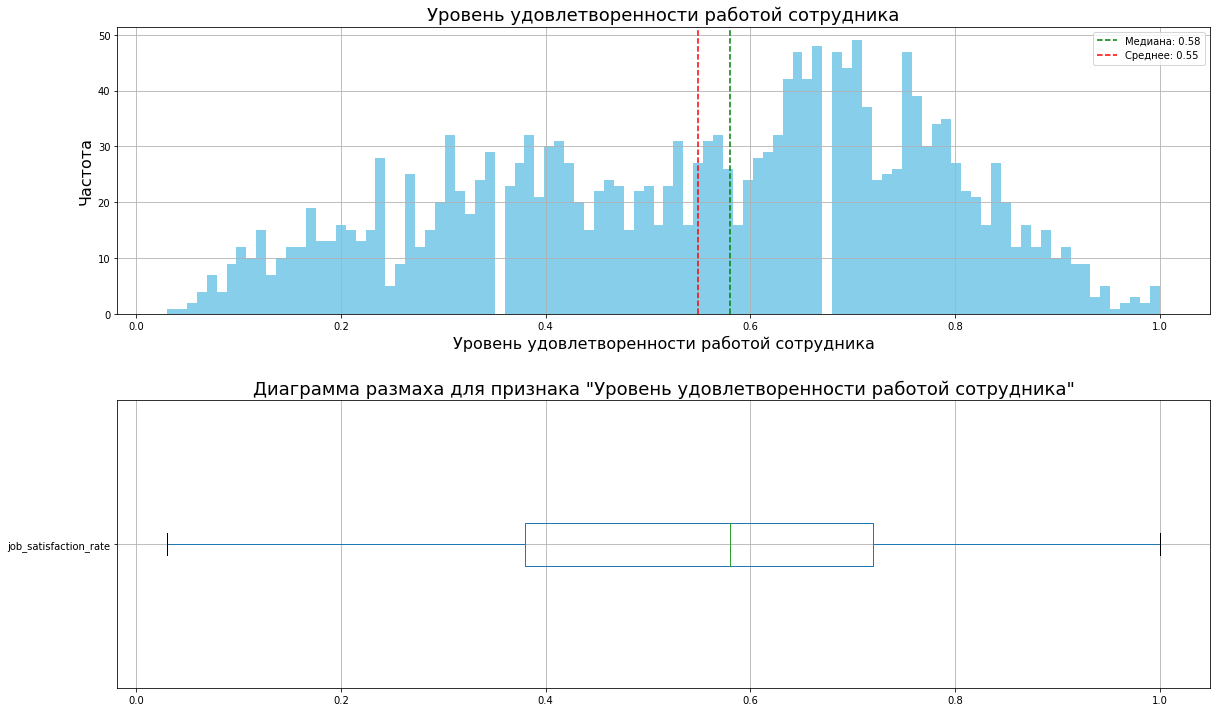

In [33]:
analyze_numerical_data(test_target_job_satisfaction_rate, 'job_satisfaction_rate',
                      'Уровень удовлетворенности работой сотрудника')

Для удобства выведем описание для числовых переменных.

In [34]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [35]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


В тестовой выборке значения целевого признака "job_satisfaction_rate" распределены в диапазоне от 0.03 до 1. Медианное значение - 0.58, среднее меньше медианного - 0.55. Стандартное отклонение - 0.22. Границы межквартильного размаха - от 0.38 до 0.72. Можно сделать вывод, что характер распределения в тестовой выборке не изменился.

Тестовая и тренировочная выборки имеют близкие распределения числовых признаков (нет значительных различий в средних, медианных значениях, в стандартных отклонениях).

Посмотрим на распределение категориальных признаков.

In [36]:
for column in ['dept', 'last_year_promo', 'last_year_violations', 'level', 'workload']:
    print(test_features[column].value_counts(normalize=True), '\n')

sales         0.381882
technology    0.227728
marketing     0.139640
purchasing    0.136637
hr            0.113614
              0.000501
Name: dept, dtype: float64 

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64 

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64 

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64 

medium    0.5215
low       0.2965
high      0.1815
          0.0005
Name: workload, dtype: float64 



В тестовом датасете видим:
- 5 отделов: 'sales'(38.2%), 'technology'(22.8%), 'marketing'(14%), 'purchasing'(13.7%), 'hr'(11.4%) и одна категория - ошибочная, содержащая пустое значение;
- 3.2% сотрудников получили повышение за последний год;
- 13.1% сотрудников нарушали трудовой договор;
- 3 уровня должностей: 'sinior'(8.6%), 'junior'(48.7%), 'middle'(42.7%);
- 3 уровня нагрузки: 'low'(29.7%), 'medium'(52.2%), 'high'(18.2%) и одна категория - ошибочная, содержащая пустое значение;

Распределения категориальных признаков тренировочной и тестовой выборки также похожи.

__Выводы__: 

- Значения целевого признака "job_satisfaction_rate" распределены в диапазоне от 0.03 до 1. Медианное значение - 0.56, среднее меньше медианного - 0.53. Стандартное отклонение - 0.23. Границы межквартильного размаха - от 0.36 до 0.71. Можно говорить о широком распределении вокруг среднего значения.

- В данных присутствует информация о сотрудниках из 5 отделов: sales (37.8%), technology (21.65%), purchasing (15.25%), marketing (13.75%), hr (11.4%). Уровень удовлетворенности работой в отделах незначительно отличается: максимальное медианное значение 0.59 в отделе purchasing, минимальное - 0.52 в отделе marketing.

- По данным нашей выборки только 3% сотрудников получили повышение за последний год. Медианное значение уровня удовлетворенности работой у таких сотрудников составляет 0.7, тогда как у тех, кто не получал повышение - 0.55.

- 14% сотрудников нарушали трудовой договор за последний год. Медианное значение уровня удовлетворенности работой у таких сотрудников в 2 раза ниже и составляет 0.3 против 0.6. 

- В датасете представлены данные о сотрудниках 3 уровней должностей: 'junior'(47.35%), 'middle'(43.6%), 'sinior'(8.95%). Наименьшее среди этих групп медианное значение уровня удовлетворенности работой наблюдается у сотрудников 'sinior'(0.54), наибольшее значение - у сотрудников 'middle'(0.58).

- Выделяют три уровня загруженности сотрудников: 'low'(30%), 'medium'(51.65%), 'high'(18.35%). Медианное значение уровня удовлетворенности работой при загрузке 'low' и 'high'- 0.58, 'medium'- 0.54.

- Признак "employment_years" имеет дискретную природу, принимает значения от 1 до 10. Медианное значение - 3, среднее больше медианного - 3.72. Стандартное отклонение - 2.54. Границы межквартильного размаха - от 2 до 6. Выбросов нет. В целом можно сказать, что согласно предоставленным данным, наибольшие медианные значения уровня удовлетворенности работой наблюдаются у сотрудников, проработавших в компании от 7 лет.

- Признак "supervisor_evaluation" имеет дискретную природу, принимает значения от 1 до 5. Медианное значение при этом - 4, среднее - 3.48. Стандартное отклонение - 1. Границы межквартильного размаха - от 3 до 4. Оценка 1 - нетипичная для нашего датасета, однако не является аномалией. Изучив предоставленные данные можно заметить, что при более высоких оценках качества работы работодателем наблюдается более высокое медианное значение уровня удовлетворенности работой сотрудника: 0.7 при оценках 4 и 5, 0.31-0.36 при оценках от 1 до 3.

- Значения признака "salary" распределены в диапазоне от 12000 до 98400. Медианное значение - 30000, среднее больше медианного - 33926.7. Стандартное отклонение - 14900.7. Границы межквартильного размаха - от 22800 до 43200. Часть наблюдений опредлена как выбросы (зарплата более 73200), однако все эти записи работников уровня "sinior" (высокий уровень - высокая зарплата, небольшая по численности группа). Значения не являются аномальными, оставим их.

- Для номинальных категориальных признаков (dept, last_year_promo, last_year_violations) будем использовать OneHotEncoder, для ранговых признаков (level, workload) - OrdinalEncoder, численные признаки (employment_years, salary, supervisor_evaluation) будем масштабировать.

- В тестовой выборке значения целевого признака "job_satisfaction_rate" распределены в диапазоне от 0.03 до 1. Медианное значение - 0.58, среднее меньше медианного - 0.55. Стандартное отклонение - 0.22. Границы межквартильного размаха - от 0.38 до 0.72. Можно сделать вывод, что характер распределения в тестовой выборке не изменился.

- Тестовая и тренировочная выборки имеют близкие распределения категориальных и числовых признаков (нет значительных различий в средних, медианных значениях, в стандартных отклонениях).

### Корреляционный анализ

Рассчитаем коэффициенты корреляции между признаками для train_job_satisfaction_rate. Будем использовать phik.

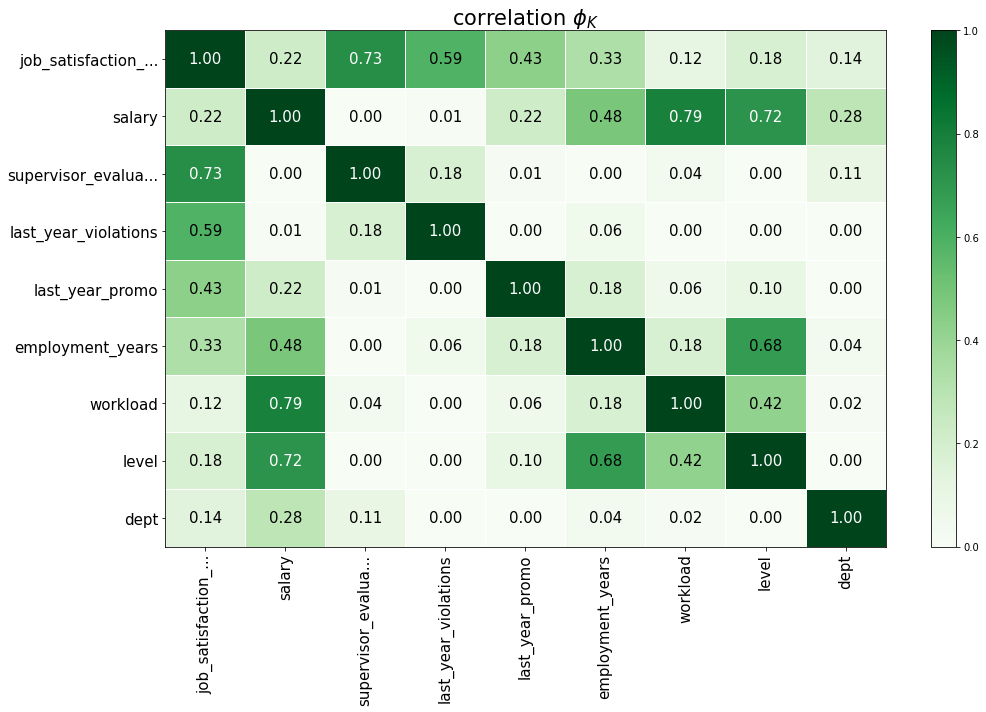

In [37]:
phik_overview = phik_matrix(train_job_satisfaction_rate.drop(columns=['id']), interval_cols=num_columns) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

Целевой признак - это "job_satisfaction_rate":
- наблюдается __высокая взаимосвязь__ с признаком 'supervisor_evaluation',
- __заметная взаимосвязь__ с признаком 'last_year_violations',
- __умеренная взаимосвязь__ с признаком 'employment_years', 'last_year_promo',
- __слабая взаимосвязь__ с признаками 'salary', 'workload', 'level', 'dept'.

Мультиколлинеарности (коффициента больше 0.9) между входными признаками нет.

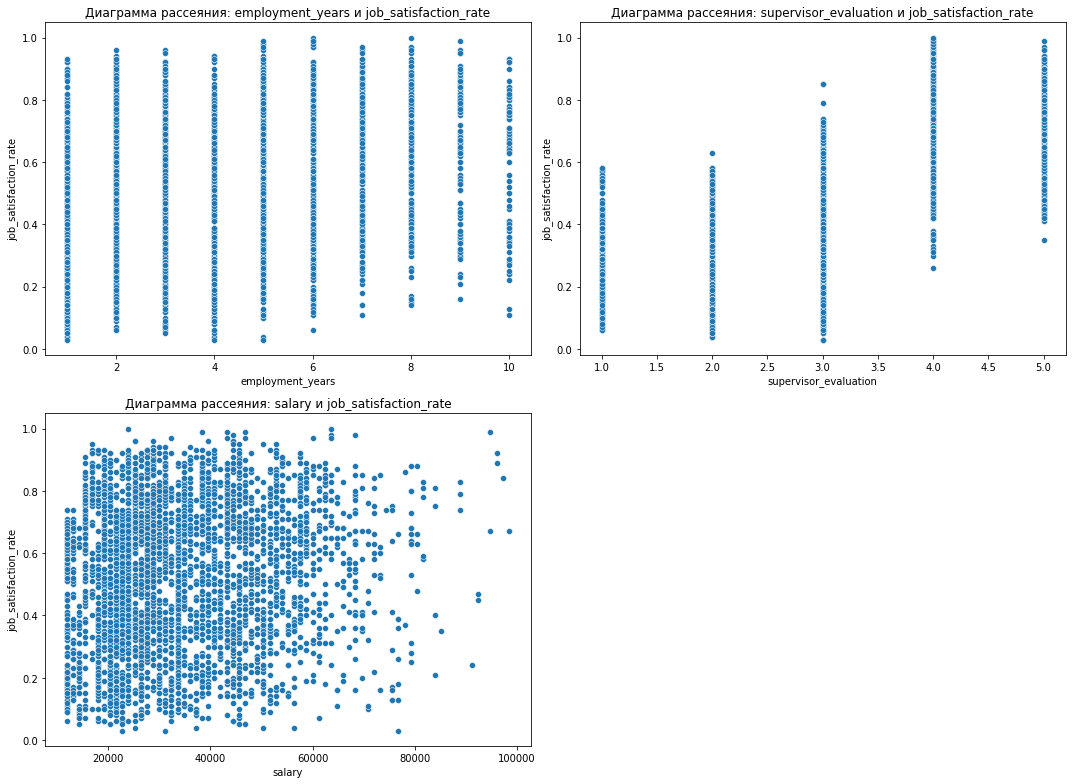

In [38]:
# Построение диаграмм рассеяния
plt.figure(figsize=(15, 16))

for i, column in enumerate(num_columns, start=1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=train_job_satisfaction_rate, x=column, y='job_satisfaction_rate')
    plt.title(f'Диаграмма рассеяния: {column} и job_satisfaction_rate')
    plt.xlabel(column)
    plt.ylabel('job_satisfaction_rate')

plt.tight_layout()
plt.show()

__Выводы__: 
- наблюдается __высокая взаимосвязь__ целевого признака с признаком 'supervisor_evaluation', __заметная взаимосвязь__ с 'last_year_violations', __умеренная взаимосвязь__ с 'employment_years', 'last_year_promo', __слабая взаимосвязь__ с признаками 'salary', 'workload', 'level', 'dept';
- мультиколлинеарности между входными признаками нет.

###  Подготовка данных

Создадим пайплайн предобработки данных.

In [39]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse=False,  handle_unknown='ignore'))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=
                               [['junior', 'middle', 'sinior'],
                                ['low', 'medium', 'high']],   
                               handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)

Удалим признак 'id', т.к. он не влияет на целевую переменную. Повторим проверку на дубликаты.

In [40]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop(columns=['id'])
train_job_satisfaction_rate.duplicated().sum()

245

In [41]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()

In [42]:
# проконтролируем изменение размера
train_job_satisfaction_rate.shape

(3755, 9)

In [43]:
# выделим признаки и целевую переменную
X_train_jsr = train_job_satisfaction_rate.drop(columns=['job_satisfaction_rate'])
y_train_jsr = train_job_satisfaction_rate['job_satisfaction_rate']

Подготовим тестовые данные. <a id="test_jsr"></a>

In [44]:
test_jsr = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')

In [45]:
test_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


In [46]:
X_test_jsr, y_test_jsr = test_jsr.drop(
    columns=['id', 'job_satisfaction_rate']), test_jsr['job_satisfaction_rate']

__Вывод__:
- подготовили пайплайн для предобработки данных (добавили кодирование и масштабирование признаков);
- удалили признак 'id', повторно провели проверку на дубликаты;
- удалили дубликаты, размер тренирововчной выборки сократился до 3755 записей;
- выделили входные признаки и целевую переменную;
- подготовили тестовые данные.

### Обучение моделей

Решаем задачу регрессии, обучение с учителем.

Для проверки качества моделей и выбора лучшей модели будем использовать метрику SMAPE(symmetric mean absolute percentage error). Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

In [47]:
# создаём функцию для оценки качества модели
def calculate_smape_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    n = len(y_true)
    sum_error = 0
    for i in range(n):
        denominator = (abs(y_true[i]) + abs(y_pred[i])) / 2
        if denominator != 0:
            sum_error += abs(y_true[i] - y_pred[i]) / denominator
    return 100 / n  * sum_error



In [48]:
def calculate_smape_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    abs_y_true, abs_y_pred = np.abs(y_true), np.abs(y_pred)
    
    denominator = (abs_y_true + abs_y_pred) / 2
    
    # маска для отбора элементов, где знаменатель не равен нулю
    valid_denominator = denominator != 0
    sum_error = np.sum(
        np.abs(y_true[valid_denominator] - y_pred[valid_denominator]) /
        denominator[valid_denominator]
    )
    return 100 / len(y_true) * sum_error

# создаём метрику smape
smape_scorer = make_scorer(calculate_smape_metric, greater_is_better=False) 

Обучим две модели: модель линейной регрессии и модель регрессии, основанную на дереве решений.

In [49]:
pipe_final_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

param_lr = {
    'preprocessor__num':
        ['passthrough', StandardScaler(), MinMaxScaler()]
}

start = time.time()

grid_search = GridSearchCV(
    pipe_final_lr,
    param_lr,
    scoring=smape_scorer,
    cv=5,
    n_jobs=-1
) 
grid_search.fit(X_train_jsr, y_train_jsr)

grid_search_time = time.time() - start

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', grid_search.best_score_)
print ('Время поиска лучших параметров:', grid_search_time, 'секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [50]:
pipe_final_dtr = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_dtr = {
    'model__max_depth':  range(7, 15), 
    'model__min_samples_split': range(2, 10), 
    'model__min_samples_leaf': range(2, 10),
    'preprocessor__num': [StandardScaler(), MinMaxScaler()]
}

start = time.time()

grid_search_dtr = GridSearchCV(
    pipe_final_dtr,
    param_dtr,
    scoring=smape_scorer,
    cv=5,
    n_jobs=-1
) 
grid_search_dtr.fit(X_train_jsr, y_train_jsr)

grid_search_time = time.time() - start

print('Лучшая модель и её параметры:\n\n', grid_search_dtr.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', grid_search_dtr.best_score_)
print ('Время поиска лучших параметров:', grid_search_time, 'секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Только регрессионная модель, основанная на деревьях, показала близкий к требуемому результат по метрике SMAPE, результат модели линейной регрессии настолько далек от требуемого значения, что не будем ее рассматривать. Узнаем метрику лучшей модели на тестовых данных.

In [51]:
print('Метрика SMAPE на тестовых данных:',
      calculate_smape_metric(y_test_jsr, grid_search_dtr.predict(X_test_jsr)))

Метрика SMAPE на тестовых данных: 13.452608782054757


In [52]:
# параметры лучшей модели
grid_search_dtr.best_params_

{'model__max_depth': 14,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 8,
 'preprocessor__num': MinMaxScaler()}

Лучшая модель показала хорошее значение метрики SMAPE на тестовой выборке - 13.45, что удовлетворяет критерию успеха.

In [53]:
# определим важность признаков
importances  = (grid_search_dtr.best_estimator_.named_steps['model']
                .feature_importances_)

ohe_feature_names = (grid_search_dtr.best_estimator_.named_steps['preprocessor']
                     .named_transformers_['ohe'].named_steps['ohe']
                     .get_feature_names_out(ohe_columns))

remainder_feature_names = [
    c for c in X_train_jsr.columns if c not in (ohe_columns + ord_columns + num_columns)]

all_feature_names = np.concatenate([ohe_feature_names,
                                    ord_columns, num_columns, remainder_feature_names])

# создадим DataFrame для важностей признаков
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# сортируем по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df

,Feature,Importance
9,supervisor_evaluation,0.670288
10,salary,0.081098
8,employment_years,0.073468
5,last_year_violations_yes,0.054194
6,level,0.051253
7,workload,0.020325
2,dept_sales,0.014357
4,last_year_promo_yes,0.012419
0,dept_marketing,0.009847
3,dept_technology,0.009126


Топ-5 самых значимых признаков в порядке убывания важности:
- supervisor_evaluation 
- salary  
- employment_years  
- last_year_violations_yes  
- level   

Посмотрим на shap значения для оценки того, как именно признаки влияют на результат.

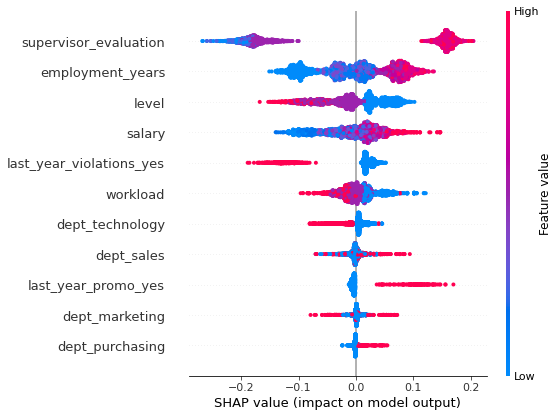

In [54]:
X_tain_jsr_transformed = grid_search_dtr.best_estimator_.named_steps['preprocessor'].transform(X_train_jsr)
shap_values = shap.TreeExplainer(
    grid_search_dtr.best_estimator_.named_steps['model']).shap_values(X_tain_jsr_transformed)
shap.summary_plot(shap_values, X_tain_jsr_transformed, feature_names=all_feature_names)

__Вывод__:
- Для предсказания уровня удовлетворенности сотрудника работой лучшей оказалась модель DecisionTreeRegressor с параметрами max_depth=14, min_samples_leaf=2, min_samples_split=8, random_state=42, масштабирование данных проводилось с помощью MinMaxScaler. Стоит отметитить, что эта модель лучше приспосабливается к нелинейным связям, а также имеет больше гиперпараметров для возможного улучшения качества модели.
- Метрика лучшей модели на тестовой выборке SMAPE = 13.45.
- Топ-5 самых значимых признаков:   
    - supervisor_evaluation 
    - salary
    - employment_years
    - last_year_violations_yes
    - level

## Предсказание увольнения сотрудника из компании

### Загрузка данных

Входные признаки тестовой выборки те же, что и в прошлой задаче, они хранятся в датасете test_features. Вспомним информацию о нем: содержит 2000 записей, данные соответствуют описанию, есть небольшое количество пропусков в столбцах dept и level, названия столбцов соответствуют змеиному регистру, типы данных определены верно.  

In [ ]:
train_quit = pd.read_csv('/datasets/train_features_quit.csv')

In [ ]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [57]:
get_head_and_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Датасет train_quit содержит 4000 записей, данные соответствуют описанию. Пропусков нет. Названия столбцов соответствуют змеиному регистру, типы данных определены верно.

In [58]:
get_head_and_info(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Датасет test_target_quit содержит 2000 записей, данные соответствуют описанию. Названия столбцов соответствуют змеиному регистру, типы данных определены верно, пропусков нет.

__Выводы__:
- загрузили данные для работы, изучили первые 5 строк и ообщую информацию о наборах данных;
- данные соответствуют описанию, названия столбцов соответствуют змеиному регистру, типы данных определены верно, пропусков нет;
- датасет train_quit содержит 4000 записей;
- датасет test_features содержит 2000 записей, есть небольшое количество пропусков в столбцах `dept` и `level`;
- датасет test_target_quit содержит 2000 записей.

### Предобработка данных

Проверим наличие дубликатов.

In [59]:
train_quit.duplicated().sum()

0

In [60]:
train_quit.duplicated(subset=['id']).sum()

0

Проверим категориальные признаки.

In [61]:
for column in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']:
    print(train_quit[column].value_counts(), '\n')

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64 

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64 

medium    2118
low       1208
high       674
Name: workload, dtype: int64 

no     3887
yes     113
Name: last_year_promo, dtype: int64 

no     3455
yes     545
Name: last_year_violations, dtype: int64 

no     2872
yes    1128
Name: quit, dtype: int64 



Проблем с категориальными признаками нет. Отметим __дисбаланс классов__ в целевом признаке.

__Выводы__:
- проверили наличие явных дубликатов и дубликатов по 'id' в данных;
- категориальные значения записаны без ошибок;
- в целевом признаке присутствует дисбаланс классов.

### Исследовательский анализ данных

In [62]:
def calculate_quit_percentages(data, column):
    """
    Функция группирует входной DataFrame по указанному столбцу
    и столбцу 'quit', подсчитывает количество записей в каждой группе
    и вычисляет процент относительно общего количества в этой группе.
    
    Параметры:
    data : датасет
    columns : название столбца
    """
    return (
        data
        .groupby([column, 'quit'])
        .agg(count=('id', 'count'))
        .assign(
            percent_of_group=lambda x: round(
                x['count'] / x.groupby(level=0)['count'].transform('sum') * 100, 2)
        )
    )

In [63]:
def plot_barh(data, title, column_to_plot):
    """
    Функция строит горизонтальную столбчатую диаграмму на основе
    указанного столбца данных и отображает частоту значений.

    Параметры:
    -----------
    data : датасет
    title : заголовок графика
    column_to_plot : название столбца, для которого будет построена диаграмма
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    data[column_to_plot].value_counts().sort_values(
        ascending=True).plot(kind='barh', ax=ax, rot=0, legend=False, color='skyblue')
    ax.set_title(title, fontsize=TITLE_SIZE)
    ax.set_ylabel(title, fontsize=LABEL_SIZE)
    ax.set_xlabel('Частота', fontsize=LABEL_SIZE)
 
    for bar in ax.patches:
        ax.annotate(f'{int(bar.get_width())}', 
            xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
            xytext=(5, 0), 
            textcoords="offset points",
            ha='left', va='center')
    plt.show()

In [64]:
def analyze_discrete_data_quit(data, column_to_analyze, title, xlabel):
    """
    Функция группирует данные по указанному столбцу и рассчитывает
    общее количество записей, количество увольнений и процент
    увольнений для каждой группы. Затем строит график, показывающий
    процент увольнений.
    
    Параметры:
    -----------
    data : датасет
    column_to_analyze : название столбца, по которому будет произведен анализ
    title : заголовок графика, отображаемый на верхней части диаграммы
    xlabel : название оси X на графике, соответствует анализируемому столбцу
    """
    analyze_discrete_data(data, column_to_analyze, title)
    agg_data =(
        data
        .groupby([column_to_analyze])
        .agg(
            all_count=('id', 'count'),
            quit_count=('quit', lambda x: x[x == 'yes'].count()),
            percent_quit=('quit', lambda x: round(x[x == 'yes'].count() / x.count() * 100, 2))
        )
    )
    print(agg_data)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    agg_data.plot(y='percent_quit', ax=ax, style='o-', legend=False)
    ax.set_title(title, fontsize=TITLE_SIZE)
    ax.set_xlabel(xlabel, fontsize=LABEL_SIZE)
    ax.set_ylabel('Процент увольнений', fontsize=LABEL_SIZE)
    ax.grid(True)
    # Добавляем значения к каждой точке
    for i, txt in enumerate(agg_data['percent_quit']):
        ax.annotate(
            txt,
            (agg_data.index[i], agg_data['percent_quit'].iloc[i]),
            textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

Рассмотрим целевой признак.

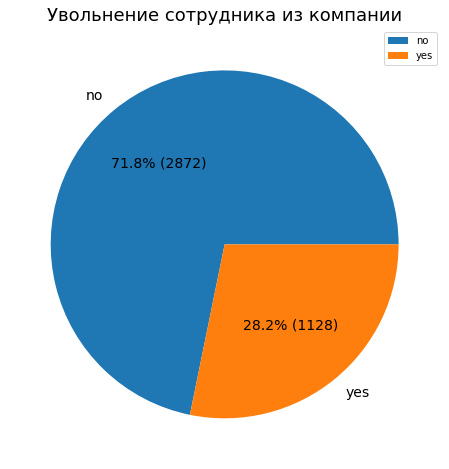

In [65]:
# тренировочная выборка
counts_by_category = train_quit.groupby('quit')['id'].count()
fig, ax = plt.subplots(figsize=(8, 8))
ax = (
    counts_by_category
    .plot.pie(
        autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, round(p * counts_by_category.sum() / 100)),
        legend=True,
        ylabel='',
        fontsize=14
        )
)
ax.set_title('Увольнение сотрудника из компании', fontsize=TITLE_SIZE)
plt.show()

In [66]:
# тестовая выборка
test_target_quit['quit'].value_counts(normalize=True)

no     0.718
yes    0.282
Name: quit, dtype: float64

Присутствует дисбаланс классов в целевой переменной. В предоставленном датасете число уволившихся сотрудников в 2,5 раза меньше, чем неуволившихся. __Стоит отметить, что соотношение классов в тренировочной и тестовой выборке схожее, выборки уже стратифицированы.__

Изучим категориальные переменные.

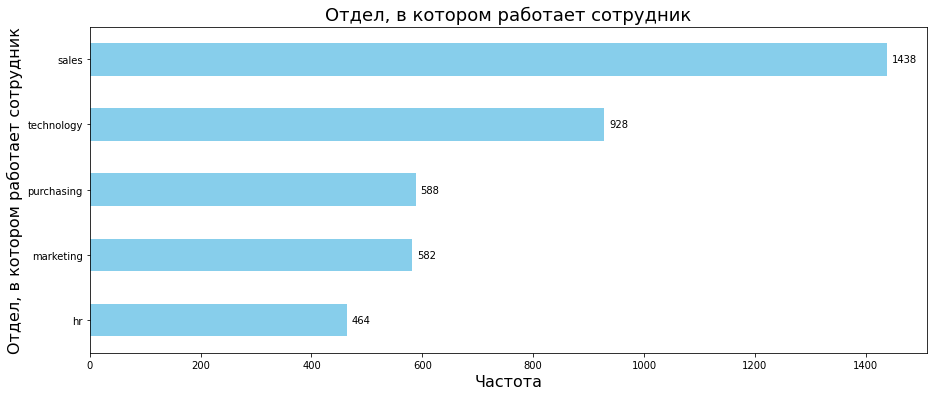

In [67]:
plot_barh(train_quit, 'Отдел, в котором работает сотрудник', 'dept')

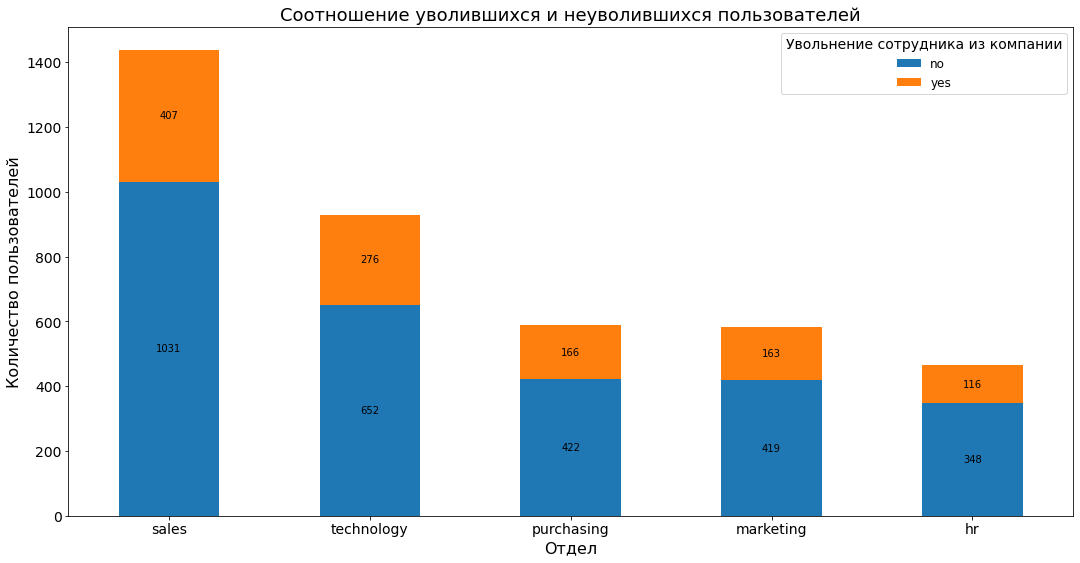

In [68]:
fig, ax = plt.subplots(figsize=(15, 6))
(
    train_quit.groupby(['dept', 'quit'])
    .size().unstack()
    .sort_values(by='yes', ascending=False) 
    .plot(kind='bar', figsize=(18, 9), fontsize = 14, ax=ax, rot=0, stacked=True)
)
ax.set_title('Cоотношение уволившихся и неуволившихся пользователей', fontsize = TITLE_SIZE)
ax.set_xlabel('Отдел', fontsize = LABEL_SIZE)
ax.set_ylabel('Количество пользователей', fontsize = LABEL_SIZE)
ax.legend(title='Увольнение сотрудника из компании', fontsize=12, title_fontsize=14)

# Подписи для каждого сегмента
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_y() + height / 2  # Центрируем по высоте
    ax.annotate(f'{int(height)}', 
                xy=(x, y),
                xytext=(0, 0),  # без смещения
                textcoords="offset points",
                ha='center', va='center', fontsize=10)

plt.show()

In [69]:
calculate_quit_percentages(train_quit, 'dept')

count  percent_of_group
dept       quit                         
hr         no      348             75.00
           yes     116             25.00
marketing  no      419             71.99
           yes     163             28.01
purchasing no      422             71.77
           yes     166             28.23
sales      no     1031             71.70
           yes     407             28.30
technology no      652             70.26
           yes     276             29.74

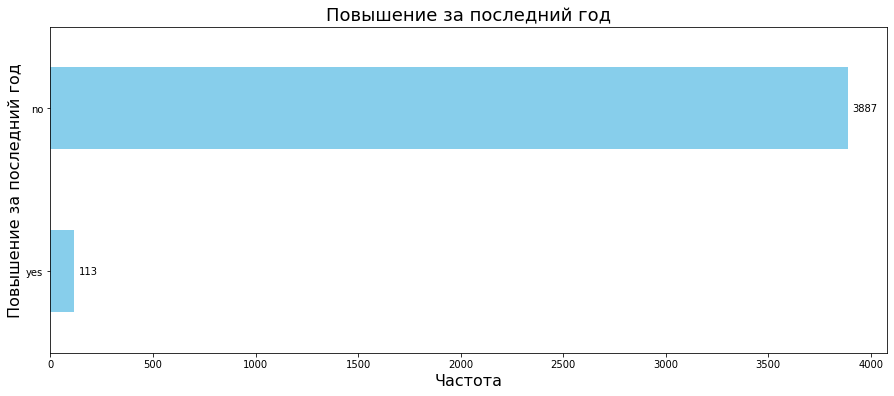

count  percent_of_group
last_year_promo quit                         
no              no     2760             71.01
                yes    1127             28.99
yes             no      112             99.12
                yes       1              0.88

In [70]:
plot_barh(train_quit, 'Повышение за последний год', 'last_year_promo')
calculate_quit_percentages(train_quit, 'last_year_promo')

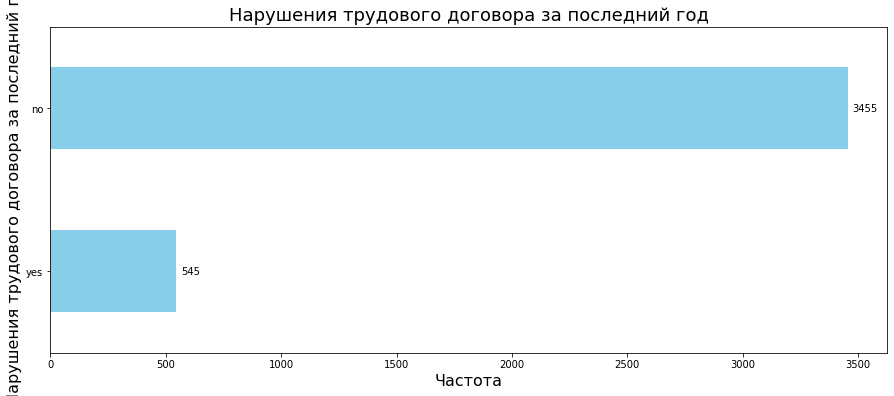

count  percent_of_group
last_year_violations quit                         
no                   no     2555             73.95
                     yes     900             26.05
yes                  no      317             58.17
                     yes     228             41.83

In [71]:
plot_barh(train_quit, 'Нарушения трудового договора за последний год', 'last_year_violations')
calculate_quit_percentages(train_quit, 'last_year_violations')

В тренировочных данных train_quit также представлена информация о сотрудниках из 5 отделов (sales, technology, purchasing, marketing, hr), по каждому из отделов от 25 до 29.74% - это случаи увольнения. Наибольший процент увольнений в отделе technology - 29.74%, наименьший в отделе hr - 25%.

По данным нашей выборки только 113 из 4000 сотрудников получили повышение за последний год. Процент увольнений среди получивших повышение - 0.88%, среди не получивших повышение - 28.99%.

Число сотрудников, нарушивших трудовой договор за последний год, составляет 545 из 4000. Среди них процент довольно высокий - 41.83%. Процент увольнений среди сотрудников, не нарушавших трудовой договор за последний год, - 26.05%.

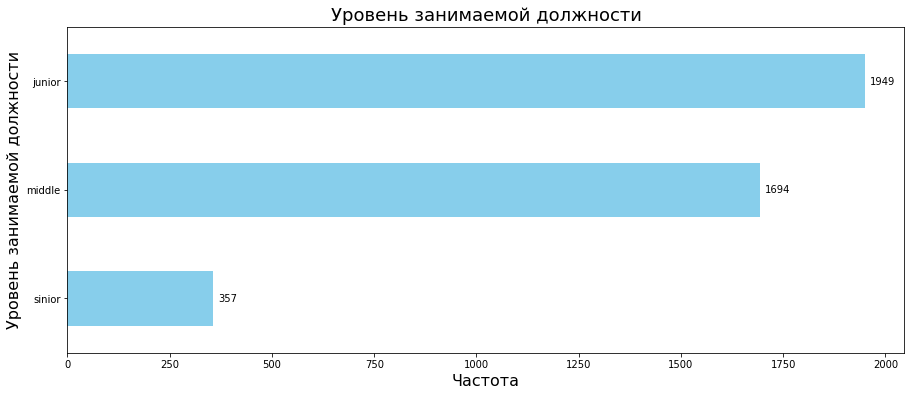

count  percent_of_group
level  quit                         
junior no      946             48.54
       yes    1003             51.46
middle no     1586             93.62
       yes     108              6.38
sinior no      340             95.24
       yes      17              4.76

In [72]:
plot_barh(train_quit, 'Уровень занимаемой должности', 'level')
calculate_quit_percentages(train_quit, 'level')

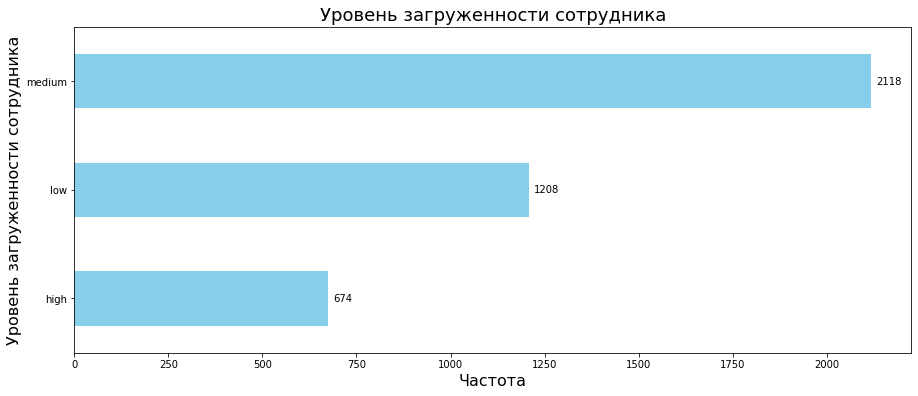

count  percent_of_group
workload quit                         
high     no      553             82.05
         yes     121             17.95
low      no      689             57.04
         yes     519             42.96
medium   no     1630             76.96
         yes     488             23.04

In [73]:
plot_barh(train_quit, 'Уровень загруженности сотрудника', 'workload')
calculate_quit_percentages(train_quit, 'workload')

В датасете train_quit также встречаются 3 уровня должностей ('junior', 'middle', 'sinior') и 3 уровня загруженности ('low', 'medium', 'high'). Очень высокий процент увольнений сотрудников уровня 'junior' (51.46%), значительно ниже у уровня 'middle'(6.38%) и 'sinior'(4.76%). Если говорить о загрузке, то наибольший процент увольнений среди сотрудников с низким уровнем загруженности - 42.96%, наименьший - при высокой загруженности  - 17.95%.

Теперь перейдем к численным признакам. 

Процент увольнений в зависимости от длительности работы в компании


count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

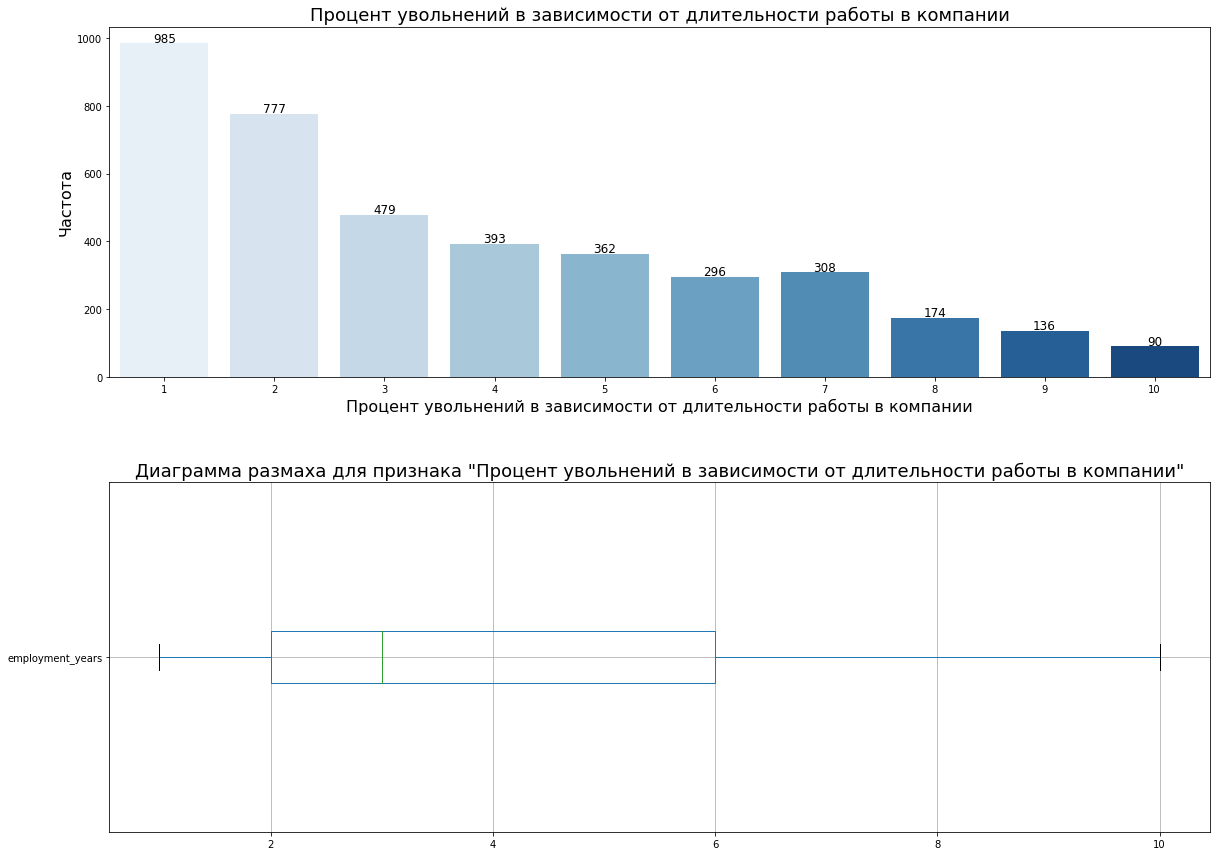

                  all_count  quit_count  percent_quit
employment_years                                     
1                       985         599         60.81
2                       777         290         37.32
3                       479         163         34.03
4                       393          27          6.87
5                       362          23          6.35
6                       296          10          3.38
7                       308           7          2.27
8                       174           3          1.72
9                       136           3          2.21
10                       90           3          3.33


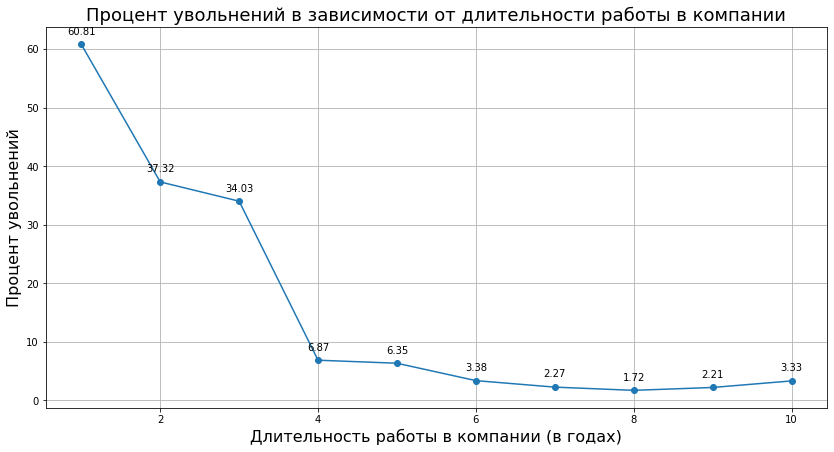

In [74]:
analyze_discrete_data_quit(
    train_quit, 'employment_years',
    'Процент увольнений в зависимости от длительности работы в компании',
    'Длительность работы в компании (в годах)'
)

Признак "employment_years" принимает значения от 1 до 10. Медианное значение - 3, среднее больше медианного - 3.7. Стандартное отклонение - 2.54. Границы межквартильного размаха - от 2 до 6. Выбросов нет. Предоставленная информация говорит о том, что наблюдается резкое снижение процента увольнений при длительности работы от 1 до 4 лет (от 60.81% до 6.87%), плавное снижение - от 4 до 8 лет (от 6.87% до 1.72%), медленный рост - от 8 до 10 лет (от 1.72% до 3.33%). 

Оценка качества работы сотрудника, которую дал руководитель


count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

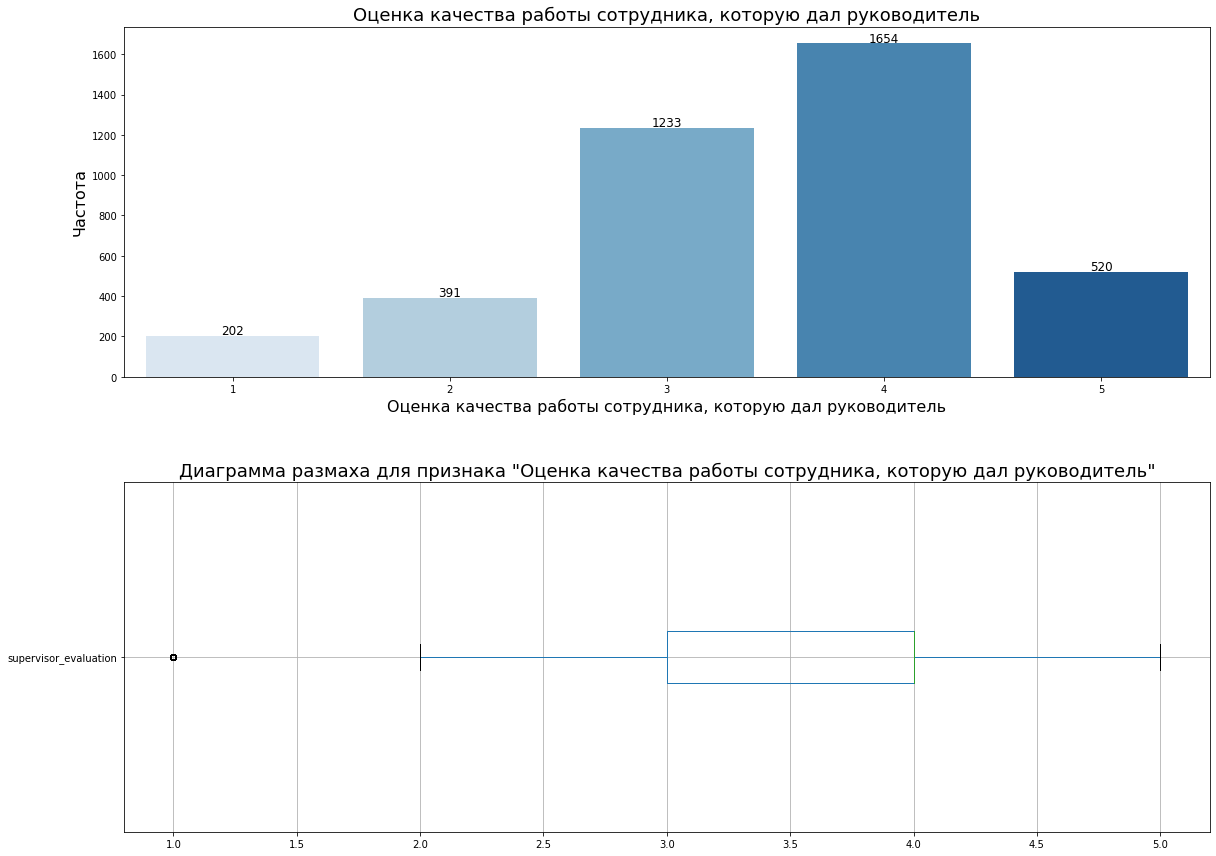

                       all_count  quit_count  percent_quit
supervisor_evaluation                                     
1                            202          95         47.03
2                            391         164         41.94
3                           1233         523         42.42
4                           1654         286         17.29
5                            520          60         11.54


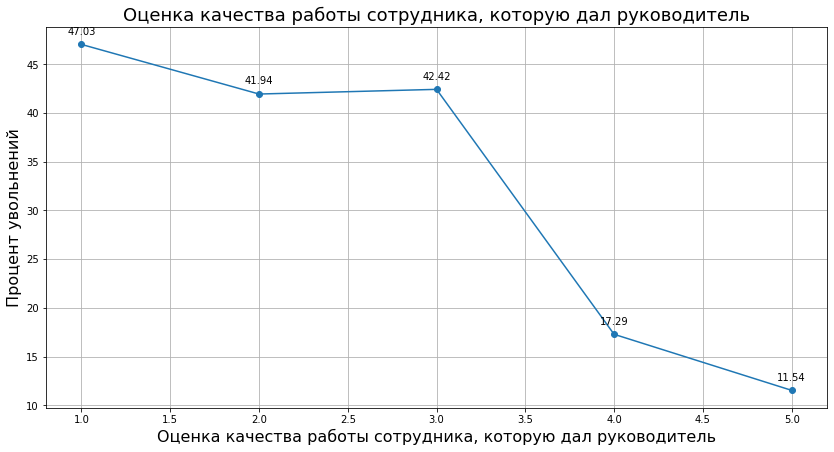

In [75]:
analyze_discrete_data_quit(
    train_quit, 'supervisor_evaluation',
    'Оценка качества работы сотрудника, которую дал руководитель',
    'Оценка качества работы сотрудника, которую дал руководитель'
)

Признак "supervisor_evaluation" принимает значения от 1 до 5. Медианное значение при этом - 4, среднее - 3.47. Стандартное отклонение - 1. Границы межквартильного размаха - от 3 до 4. Оценка 1 - нетипичная, однако не является аномалией. Оценкам 1-3 соответсвует более высокий процент увольнений - 41.94-47.03%, при оценках 4-5 процент увольнений намного ниже - 11.54-17.29%. 

Зарплата сотрудника


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

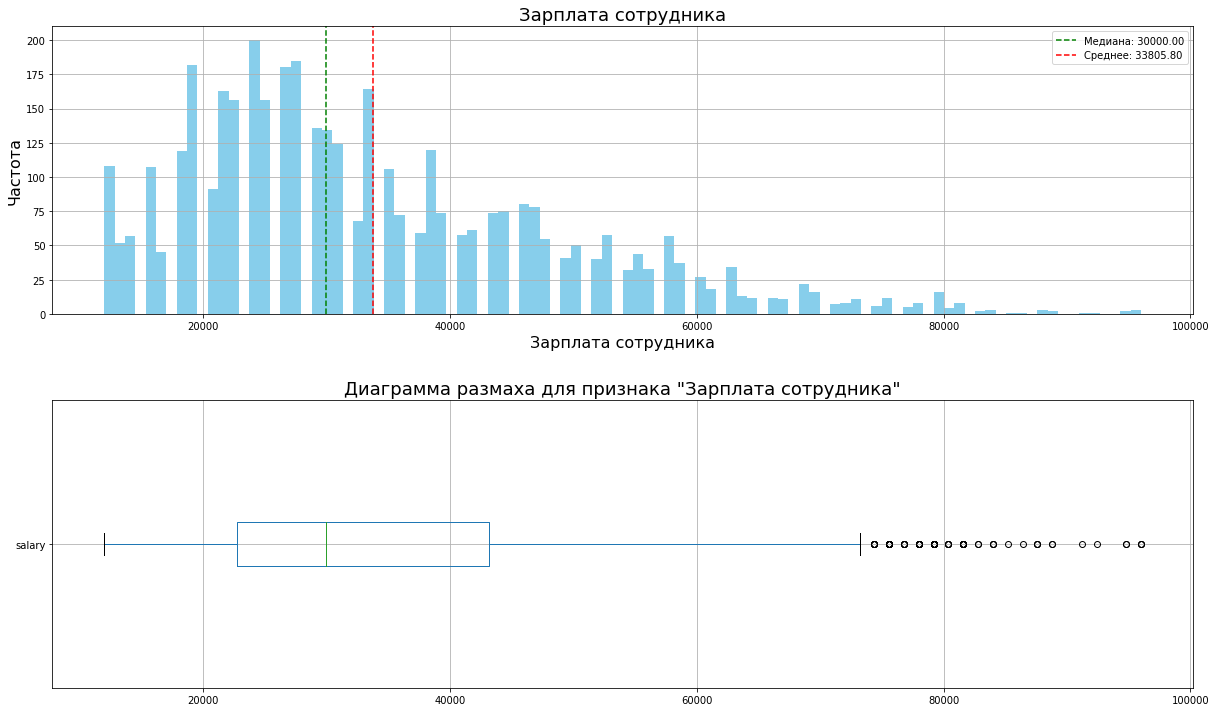

In [76]:
analyze_numerical_data(train_quit, 'salary', 'Зарплата сотрудника', bins_number=100)

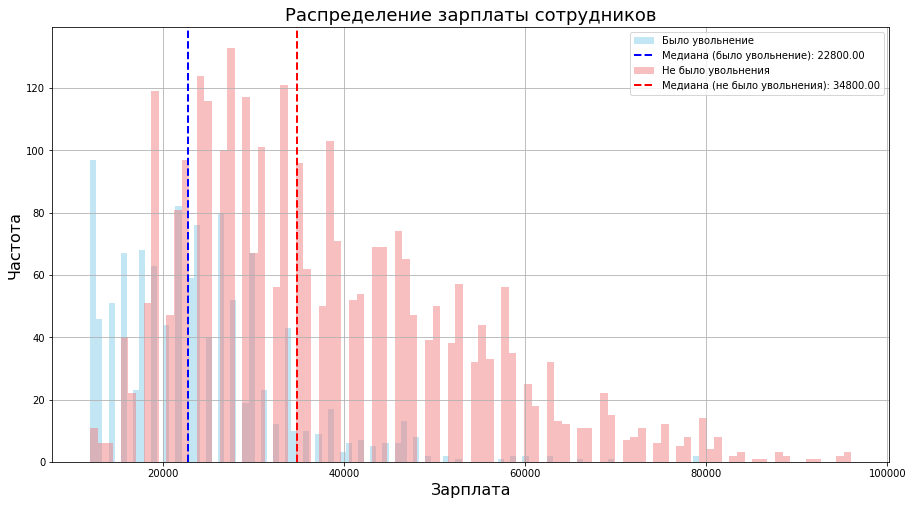

In [77]:
plt.figure(figsize=(15, 8))

# Построение гистограммы для случаев увольнений
plt.hist(
    train_quit[train_quit['quit'] == 'yes']['salary'],
    bins=100, color='skyblue', alpha=0.5, label='Было увольнение')
median_1 = train_quit[train_quit['quit'] == 'yes']['salary'].median()
plt.axvline(median_1, color='blue', linestyle='dashed', linewidth=2,
            label=f'Медиана (было увольнение): {median_1:.2f}')

# Построение гистограммы для случаев, когда увольнения не было
plt.hist(
    train_quit[train_quit['quit'] == 'no']['salary'],
    bins=100, color='lightcoral', alpha=0.5, label='Не было увольнения')
median_2 = train_quit[train_quit['quit'] == 'no']['salary'].median()
plt.axvline(median_2, color='red', linestyle='dashed', linewidth=2,
            label=f'Медиана (не было увольнения): {median_2:.2f}')

plt.title('Распределение зарплаты сотрудников', fontsize=TITLE_SIZE)
plt.xlabel('Зарплата', fontsize=LABEL_SIZE)
plt.ylabel('Частота', fontsize=LABEL_SIZE)
plt.legend()
plt.grid(True) 
plt.legend()
plt.show()

Значения признака "salary" распределены в диапазоне от 12000 до 96400. Медианное значение - 30000, среднее больше медианного - 33805.8. Стандартное отклонение - 15152.42. Границы межквартильного размаха - от 22800 до 43200. Часть наблюдений опредлена как выбросы, но это не аномалии (как мы уже рассуждали ранее: высокий уровень - высокая зарплата). Если сравнивать распределение зарплаты уволившихся и неуволившихся сотрудников, то заметно, что зарплата неуволившихся сотрудников распределена в более широком диапазоне, медианное значение значительно выше.

Посмотрим на признаки для уволившихся сотрудников.

In [78]:
train_quit[train_quit['quit'] == 'yes'].describe()

,id,employment_years,supervisor_evaluation,salary
count,1128.000000,1128.000000,1128.000000,1128.000000
mean,544544.457447,1.844858,3.046099,23885.106383
std,258059.498361,1.274920,0.973291,9351.599505
min,100222.000000,1.000000,1.000000,12000.000000
25%,325073.000000,1.000000,3.000000,16800.000000
50%,545003.500000,1.000000,3.000000,22800.000000
75%,756296.000000,2.000000,4.000000,27600.000000
max,999158.000000,10.000000,5.000000,79200.000000


In [79]:
train_quit[train_quit['quit'] == 'no']['salary'].median()

34800.0

In [80]:
(
    train_quit[train_quit['quit'] == 'yes'][
        ['dept', 'level', 'workload', 'last_year_promo',
        'last_year_violations']].mode()
)

,dept,level,workload,last_year_promo,last_year_violations
0,sales,junior,low,no,no


__Портрет «уволившегося сотрудника»__:
- работает в отделе 'technology' или 'sales' (наибольший процент увольнений / наибольшее количество уволившихся)
- уровень занимаемой должности 'junior',
- уровень загруженности сотрудника 'low',
- не получал повышение за последний год,
- не нарушал трудовой договор за последний год,
- длительность работы в компании - от 1 до 2 лет (межквартильный размах),
- оценка качества работы сотрудника - 3 или 4 (межквартильный размах),
- медианная ежемесячная зарплата - 23885 (у сотрудников, оставшихся в компании - 34800).

Проверим, __есть ли зависимость между уровнем удовлетворенности сотрудника работой в компании и тем, уволится ли сотрудник__. Для этого мы изучим тестовую выборку с обоими признаками (_использование тестовой выборки оговорено в  проекте)_.

In [81]:
full_test = test_jsr.merge(test_target_quit, on='id', how='left')

In [82]:
# проверим количество признаков
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [83]:
full_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


Визуализируем распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 

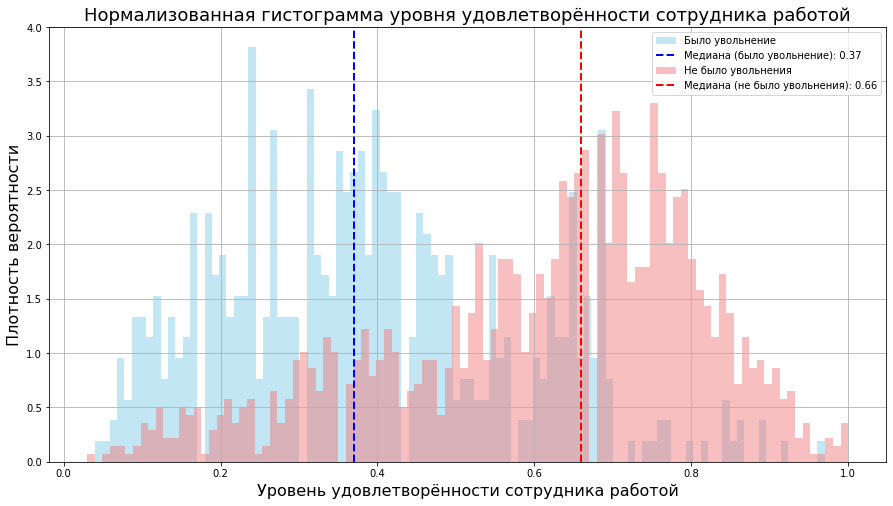

In [84]:
plt.figure(figsize=(15, 8))

# Построение гистограммы для случаев увольнений
plt.hist(
    full_test[full_test['quit'] == 'yes']['job_satisfaction_rate'],
    bins=100, color='skyblue', alpha=0.5, label='Было увольнение', density=True)
median_1 = full_test[full_test['quit'] == 'yes']['job_satisfaction_rate'].median()
plt.axvline(median_1, color='blue', linestyle='dashed', linewidth=2,
            label=f'Медиана (было увольнение): {median_1:.2f}')

# Построение гистограммы для случаев, когда увольнения не было
plt.hist(
    full_test[full_test['quit'] == 'no']['job_satisfaction_rate'],
    bins=100, color='lightcoral', alpha=0.5, label='Не было увольнения', density=True)
median_2 = full_test[full_test['quit'] == 'no']['job_satisfaction_rate'].median()
plt.axvline(median_2, color='red', linestyle='dashed', linewidth=2,
            label=f'Медиана (не было увольнения): {median_2:.2f}')

plt.title('Нормализованная гистограмма уровня удовлетворённости сотрудника работой', fontsize=TITLE_SIZE)
plt.xlabel('Уровень удовлетворённости сотрудника работой', fontsize=LABEL_SIZE)
plt.ylabel('Плотность вероятности', fontsize=LABEL_SIZE)
plt.legend()
plt.grid(True) 
plt.legend()
plt.show()

Заметно различие в распределениях уровня удовлетворённости работой сотрудников двух групп. Медианное значение для оставшихся сотрудников почти в 2 раза превышает медианное значение для уволившихся. Можно говорить о наличии взаимосвязи между этими признаками.

__Вывод__:
- В предоставленном датасете число уволившихся сотрудников в 2,5 раза меньше, чем неуволившихся. Присутствует дисбаланс классов в целевой переменной.  В начале моделирования будем пробовать решить эту проблему с помощью стратификации.
- В тренировочных данных train_quit также представлена информация о сотрудниках из 5 отделов (sales, technology, purchasing, marketing, hr), по каждому из отделов от 25 до 29.74% - это случаи увольнения. Наибольший процент увольнений в отделе technology - 29.74%, наименьший в отделе hr - 25%.
- По данным нашей выборки только 113 из 4000 сотрудников получили повышение за последний год. Процент увольнений среди получивших повышение - 0.88%, среди не получивших повышение - 28.99%.
- Число сотрудников, нарушивших трудовой договор за последний год, составляет 545 из 4000. Среди них процент довольно высокий - 41.83%. Процент увольнений среди сотрудников, не нарушавших трудовой договор за последний год, - 26.05%.
- Встречаются 3 уровня должностей ('junior', 'middle', 'sinior') и 3 уровня загруженности ('low', 'medium', 'high'). Очень высокий процент увольнений сотрудников уровня 'junior' (51.46%), значительно ниже у уровня 'middle'(6.38%) и 'sinior'(4.76%). Если говорить о загрузке, то наибольший процент увольнений среди сотрудников с низким уровнем загруженности - 42.96%, наименьший - при высокой загруженности - 17.95%.
- Признак "employment_years" принимает значения от 1 до 10. Медианное значение - 3, среднее больше медианного - 3.7. Стандартное отклонение - 2.54. Границы межквартильного размаха - от 2 до 6. Выбросов нет. Предоставленная информация говорит о том, что наблюдается резкое снижение процента увольнений при длительности работы от 1 до 4 лет (от 60.81% до 6.87%), плавное снижение - от 4 до 8 лет (от 6.87% до 1.72%), медленный рост - от 8 до 10 лет (от 1.72% до 3.33%).
- Признак "supervisor_evaluation" принимает значения от 1 до 5. Медианное значение при этом - 4, среднее - 3.47. Стандартное отклонение - 1. Границы межквартильного размаха - от 3 до 4. Оценка 1 - нетипичная, однако не является аномалией. Оценкам 1-3 соответсвует более высокий процент увольнений - 41.94-47.03%, при оценках 4-5 процент увольнений намного ниже - 11.54-17.29%.
- Значения признака "salary" распределены в диапазоне от 12000 до 96400. Медианное значение - 30000, среднее больше медианного - 33805.8. Стандартное отклонение - 15152.42. Границы межквартильного размаха - от 22800 до 43200. Часть наблюдений опредлена как выбросы, но это не аномалии (как мы уже рассуждали ранее: высокий уровень - высокая зарплата). Если сравнивать распределение зарплаты уволившихся и неуволившихся сотрудников, то заметно, что зарплата неуволившихся сотрудников распределена в более широком диапазоне, медианное значение значительно выше.
- Составили __портрет уволившегося сотрудника__ (использовали наиболее частые значения категориальных признаков,  медианные значения, межквартильный размах для числовых):
    - работает в отделе 'technology' или 'sales' (наибольший процент увольнений / наибольшее количество уволившихся)
    - уровень занимаемой должности 'junior',
    - уровень загруженности сотрудника 'low',
    - не получал повышение за последний год,
    - не нарушал трудовой договор за последний год,
    - длительность работы в компании - от 1 до 2 лет (межквартильный размах),
    - оценка качества работы сотрудника - 3 или 4 (межквартильный размах),
    - медианная ежемесячная зарплата - 23885 (у сотрудников, оставшихся в компании - 34800).
- Заметно различие в распределениях уровня удовлетворённости работой сотрудников двух групп. Медианное значение для оставшихся сотрудников почти в 2 раза превышает медианное значение для уволившихся. Можно говорить о наличии взаимосвязи между этими признаками.

### Добавление нового входного признака

Т.к. мы выявили наличие зависимости между уровнем удовлетворённости работой и увольнением, добавим к нашей тренировочной выборке признак job_satisfaction_rate. Значения нам предскажет лучшая модель, найденная выше.

In [85]:
train_quit['job_satisfaction_rate'] = grid_search_dtr.predict(train_quit)

In [86]:
get_head_and_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.653333
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.848000
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB


К тестовой выборке также добавим предсказания нашей модели. 

In [87]:
test_quit = test_features.copy()
test_quit['job_satisfaction_rate'] = grid_search_dtr.predict(test_quit)

In [88]:
get_head_and_info(test_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.855000
1,686555,hr,junior,medium,1,no,no,4,30000,0.676667
2,467458,sales,middle,low,5,no,no,4,19200,0.643333
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.816667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


Сравним признак 'job_satisfaction_rate' в тренировочных и тестовых данных.

In [89]:
train_quit['job_satisfaction_rate'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,4000.0,0.537468,0.216556,0.06,0.35,0.544,0.684,0.97


In [90]:
test_quit['job_satisfaction_rate'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.549953,0.216639,0.06,0.3575,0.577083,0.702,0.97


Медианное значение уровня удовлетворённости сотрудника работой в тестовом датасете немного больше, межквартильный размах также смещен в сторону больших значений, однако в целом сильных различий не наблюдается.

__Выводы__:
- добавили в тренировочный и тестовый датасеты колонку с уровнем удовлетворённости сотрудника, предсказанным нашей моделью.

### Корреляционный анализ

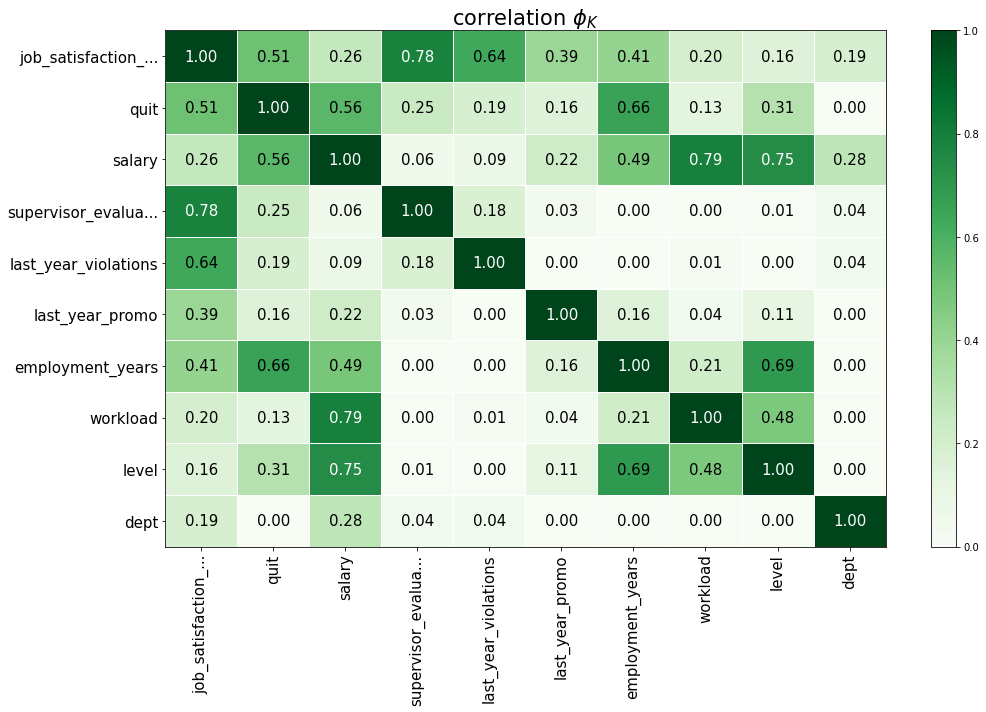

In [91]:
num_col_names = train_quit.drop(columns=['id']).select_dtypes(
    include='number').columns.tolist()

phik_overview = phik_matrix(
    train_quit.drop(columns=['id']), interval_cols=num_col_names)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

Целевой признак - это "quit":
- заметная взаимосвязь с признаками 'job_satisfaction_rate', 'salary', 'employment_years',
- умеренная взаимосвязь с признаком 'level', 
- слабая взаимосвязь с признаками 'supervisor_evaluation', 'last_year_violations', 'last_year_promo', 'workload',
- не выявлена взаимосвязь с признаком 'dept'.

Мультиколлинеарности (коффициента больше 0.9) между входными признаками нет.

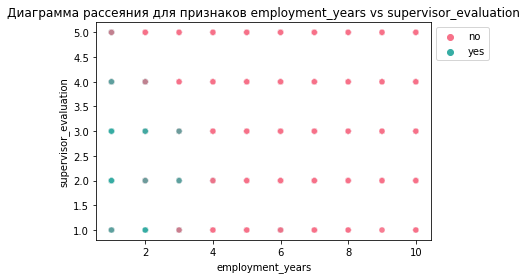

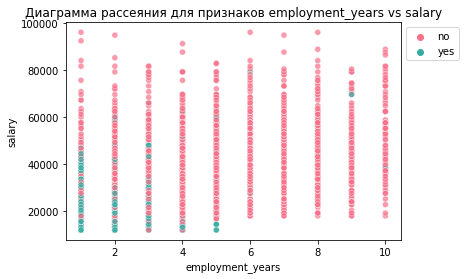

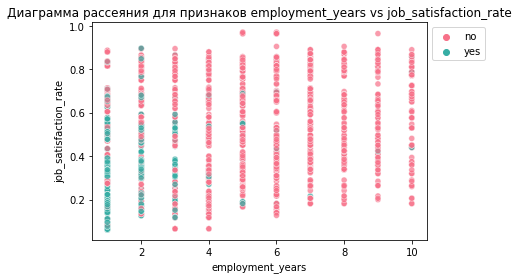

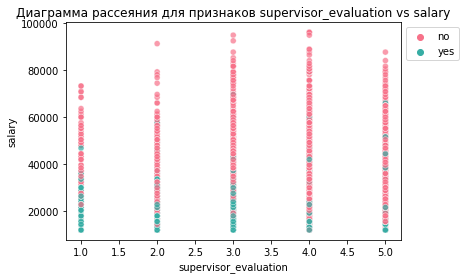

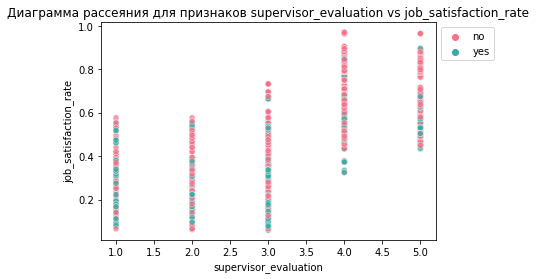

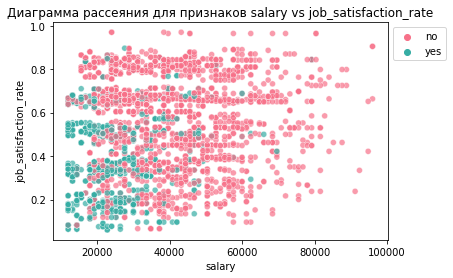

In [92]:
# Создаем комбинации из числовых признаков для построения диаграмм рассеяния
combinations = list(itertools.combinations(num_col_names, 2))

for comb in combinations:
    plt.figure()
    sns.scatterplot(data=train_quit, x=comb[0], y=comb[1], hue='quit', palette='husl', alpha=0.7)
    plt.title(f"Диаграмма рассеяния для признаков {comb[0]} vs {comb[1]}")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

__Вывод__:
- Выявили наличие заметной взаимосвязи целевого признака 'quit' с признаками 'job_satisfaction_rate', 'salary', 'employment_years', умеренной взаимосвязи с признаком 'level', слабой взаимосвязи с признаками 'supervisor_evaluation', 'last_year_violations', 'last_year_promo', 'workload', не выявлена взаимосвязь с признаком 'dept',
- мультиколлинеарности (коффициента больше 0.9) между входными признаками нет.    

### Подготовка данных

In [93]:
# обновим список числовых признаков
num_columns = train_quit.drop(
    columns=['id']).select_dtypes(include='number').columns.tolist()

Удалим признак 'id', т.к. он не влияет на целевую переменную. Повторим проверку на дубликаты.

In [94]:
train_quit = train_quit.drop(columns=['id'])
train_quit.duplicated().sum()

1413

In [95]:
train_quit = train_quit.drop_duplicates()

In [96]:
# проконтролируем изменение размера
train_quit.shape

(2587, 10)

Пайплайн для предобработки данных изменять не нужно.

In [97]:
# выделяем признаки и целевую переменную
X_train_quit = train_quit.drop(columns=['quit'])
y_train_quit = train_quit['quit']

In [98]:
test_quit = test_quit.merge(test_target_quit, on='id', how='left')
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [99]:
X_test_quit = test_quit.drop(columns=['id', 'quit'])
y_test_quit = test_quit['quit']

__Вывод__:
- будем использовать уже созданный пайплайн предобработки данных, в котором будет осуществляться заполнение пропусков, кодирование и масштабирование данных; 
- удалили признак 'id', повторно провели проверку на дубликаты;
- удалили дубликаты, размер тренирововчной выборки сократился до 2587 записей;
- выделили входные признаки и целевую переменную;
- подготовили тестовые данные.

### Обучение модели

Решаем задачу классификации, обучение с учителем, наблюдается дисбаланс классов в целевом признаке, соотношение классов в тестовой и тренировочной выборке схожее, на данный момент дополнительных действий для решения вопроса дисбаланса классов от нас не требуется.

В качестве метрики оценки качества будем использовать ROC-AUC, критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. 

In [100]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

parameters = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 20),   
        'models__max_features': range(2, 9),  
        'models__min_samples_split': range(2, 15),  
        'models__min_samples_leaf': range(1, 15), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
        
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='linear')],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

In [101]:
start = time.time()

randomized_search = RandomizedSearchCV(
    pipe_final, 
    parameters, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_quit, y_train_quit)

randomized_search_time = time.time() - start

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)
print ('Время поиска лучших параметров:', randomized_search_time, 'секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Выведем информацию о 10 лучших моделях.

In [102]:
# Извлечение результатов
results = pd.DataFrame(randomized_search.cv_results_)
results[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
9,1,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.900967,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 12, 'models__min_samples_leaf': 9, 'models__max_features': 6, 'models__max_depth': 5, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
4,2,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.896565,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 14, 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models__max_depth': 7, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
2,3,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.891727,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 12, 'models__max_features': 8, 'models__max_depth': 19, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
7,4,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.884616,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 11, 'models__min_samples_leaf': 5, 'models__max_features': 6, 'models__max_depth': 13, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
5,5,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.883428,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 5, 'models__max_features': 6, 'models__max_depth': 11, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
1,6,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.881103,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 6, 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
6,7,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.875662,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 9, 'models__min_samples_leaf': 3, 'models__max_features': 6, 'models__max_depth': 19, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
0,8,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.867708,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 6, 'models__max_features': 3, 'models__max_depth': 11, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
3,9,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.859379,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_features': 5, 'models__max_depth': 9, 'models': DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9, min_samples_split=12, random_state=42)}"
8,10,"DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=9,\n min_samples_split=12, random_state=42)",0.841544,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 1, 'models__max_features': 4, 'models__max_depth': 11, 'model

Отметим, что топ-10 моделей - это деревья.

In [103]:
# узнаем, как закодировался таргет
best_model = randomized_search.best_estimator_
print(best_model.classes_)

['no' 'yes']


In [104]:
print('Метрика ROC-AUC на тестовых данных:',
      roc_auc_score(y_test_quit, randomized_search.predict_proba(X_test_quit)[:, 1]))

Метрика ROC-AUC на тестовых данных: 0.9156208637073034


Лучшей моделью оказалось дерево DecisionTreeClassifier с гиперпараметрами max_depth=5, max_features=6,
min_samples_leaf=9, min_samples_split=12, random_state=42. Значение метрики ROC-AUC на тестовой выборке 0.92, что удовлетворяет критерию успеха.

In [105]:
# определим важность признаков
importances  = (randomized_search.best_estimator_.named_steps['models']
                .feature_importances_)

ohe_feature_names = (randomized_search.best_estimator_.named_steps['preprocessor']
                     .named_transformers_['ohe'].named_steps['ohe']
                     .get_feature_names_out(ohe_columns))

remainder_feature_names = [c for c in X_train_jsr.columns if c not in (ohe_columns + ord_columns + num_columns)]

all_feature_names = np.concatenate([ohe_feature_names, ord_columns, num_columns, remainder_feature_names])

# Создаем DataFrame для важностей признаков
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Сортируем по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df

,Feature,Importance
8,employment_years,0.430109
6,level,0.222191
11,job_satisfaction_rate,0.199571
7,workload,0.104097
9,supervisor_evaluation,0.023460
10,salary,0.019454
2,dept_sales,0.000977
1,dept_purchasing,0.000142
0,dept_marketing,0.000000
3,dept_technology,0.000000


Если посмотреть на важность признаков, то наиболее важными для нашей модели являются employment_years, job_satisfaction_rate, level, salary, supervisor_evaluation, workload. Можем упростить модель путем исключения малозначимых признаков.

In [106]:
# выбираем только необходимые признаки для обучения
selected_features = ['job_satisfaction_rate', 'employment_years',
                     'level', 'supervisor_evaluation', 'salary', 'workload']

# создадим списки с названиями признаков
ord_columns = ['level',  'workload']
num_columns = ['employment_years', 'job_satisfaction_rate', 'salary', 'supervisor_evaluation']

# обновляем X_train, оставляя только выбранные признаки
X_train_quit_reduced = X_train_quit[selected_features]

# обновляем пайплайн для подготовки данных с новыми признаками
reduced_data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),  
        ('num', MinMaxScaler(), num_columns),
    ],
    remainder='passthrough'
)

reduced_pipe_final= Pipeline([
    ('preprocessor', reduced_data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

parameters = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20), 
        'models__max_features': range(2, 9), 
        'models__min_samples_split': range(2, 15), 
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
        
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='linear')],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

start = time.time()

reduced_randomized_search = RandomizedSearchCV(
    reduced_pipe_final, 
    parameters, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
reduced_randomized_search.fit(X_train_quit_reduced, y_train_quit)

reduced_randomized_search_time = time.time() - start

print('Лучшая модель и её параметры:\n\n', reduced_randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', reduced_randomized_search.best_score_)
print ('Время поиска лучших параметров:', reduced_randomized_search_time, 'секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

In [107]:
reduced_randomized_search.best_estimator_.classes_

array(['no', 'yes'], dtype=object)

In [108]:
print('Метрика ROC-AUC на тестовых данных:',
      roc_auc_score(y_test_quit, reduced_randomized_search.predict_proba(X_test_quit)[:, 1]))

Метрика ROC-AUC на тестовых данных: 0.9128921452419052


In [109]:
reduced_randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__min_samples_split': 14,
 'models__min_samples_leaf': 3,
 'models__max_features': 5,
 'models__max_depth': 4,
 'models': DecisionTreeClassifier(max_depth=4, max_features=5, min_samples_leaf=3,
                        min_samples_split=14, random_state=42)}

In [110]:
best_model = reduced_randomized_search.best_estimator_.named_steps['models']

importances = best_model.feature_importances_

# Получаем имена признаков из ColumnTransformer
column_transformer = reduced_randomized_search.best_estimator_.named_steps['preprocessor']
feature_names = []

for name, transformer, columns in column_transformer.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

# Создаем DataFrame для важностей признаков
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Сортируем по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
0,level,0.532960
5,supervisor_evaluation,0.192319
3,job_satisfaction_rate,0.109845
2,employment_years,0.078497
1,workload,0.052681
4,salary,0.033698


Мы удалили малозначимые признаки, это сделало модель более устойчивой и упростило ее интерпретацию, значение метрики на тестовой выборке - 0.91. 

__Выводы__:
- Для предсказания увольнения сотрудника лучшей оказалась модель DecisionTreeClassifier с параметрами max_depth=4, min_samples_leaf=3, min_samples_split=14, max_features=5,random_state=42, масштабирование данных проводилось с помощью MinMaxScaler. Для улучшения качества модели мы убрали малозначительные признаки и использовали только самые значимые: job_satisfaction_rate, employment_years, level, workload, salary, supervisor_evaluation.
- Метрика лучшей модели на тестовой выборке ROC-AUC = 0.91.
- Значимость признаков в порядке убывания: 
    - level  
    - supervisor_evaluation
    - job_satisfaction_rate
    - employment_years    
    - workload
    - salary       

## Общий вывод

Компания «Работа с заботой» предоставила нам данные с характеристиками сотрудников. Мы решали 2 задачи: предсказать уровень удовлетворенности сотрудника работой и предсказать увольнение сотрудника.  

Были предоставлены 2 тренировочные выборки, 2 датасета с целевыми признаками и датасет с входными признаками. 
Для решения кажой из задач мы осуществляли __загрузку данных__, проверяли, что данные загрузились корректно и соответствуют описанию, анализировали пропуски в данных. На этапе __предобработки данных__ проверяли наличие дубликатов, ошибок в категориальных значениях, анализировали пропуски.

Мы провели __исследовательский и корреляционный анализ данных__ для каждой из задач.

__Задача 1__: предсказание уровня удовлетворенности сотрудника работой

- Значения __целевого признака__ "job_satisfaction_rate" распределены в диапазоне от 0.03 до 1. Медианное значение - 0.56, среднее меньше медианного - 0.53. Стандартное отклонение - 0.23. Границы межквартильного размаха - от 0.36 до 0.71. Можно говорить о широком распределении вокруг среднего значения.

- В данных присутствует информация о сотрудниках из 5 отделов: sales (37.8%), technology (21.65%), purchasing (15.25%), marketing (13.75%), hr (11.4%). Уровень удовлетворенности работой в отделах незначительно отличается: максимальное медианное значение 0.59 в отделе purchasing, минимальное - 0.52 в отделе marketing.

- По данным нашей выборки только 3% сотрудников получили повышение за последний год. Медианное значение уровня удовлетворенности работой у таких сотрудников составляет 0.7, тогда как у тех, кто не получал повышение - 0.55.

- 14% сотрудников нарушали трудовой договор за последний год. Медианное значение уровня удовлетворенности работой у таких сотрудников в 2 раза ниже и составляет 0.3 против 0.6. 

- В датасете представлены данные о сотрудниках 3 уровней должностей: 'junior'(47.35%), 'middle'(43.6%), 'sinior'(8.95%). Наименьшее среди этих групп медианное значение уровня удовлетворенности работой наблюдается у сотрудников 'sinior'(0.54), наибольшее значение - у сотрудников 'middle'(0.58).

- Выделяют три уровня загруженности сотрудников: 'low'(30%), 'medium'(51.65%), 'high'(18.35%). Медианное значение уровня удовлетворенности работой при загрузке 'low' и 'high'- 0.58, 'medium'- 0.54.

- Признак "employment_years" имеет дискретную природу, принимает значения от 1 до 10. Медианное значение - 3, среднее больше медианного - 3.72. Стандартное отклонение - 2.54. Границы межквартильного размаха - от 2 до 6. Выбросов нет. В целом можно сказать, что согласно предоставленным данным, наибольшие медианные значения уровня удовлетворенности работой наблюдаются у сотрудников, проработавших в компании от 7 лет.

- Признак "supervisor_evaluation" имеет дискретную природу, принимает значения от 1 до 5. Медианное значение при этом - 4, среднее - 3.48. Стандартное отклонение - 1. Границы межквартильного размаха - от 3 до 4. Оценка 1 - нетипичная для нашего датасета, однако не является аномалией. При более высоких оценках качества работы работодателем наблюдается более высокое медианное значение уровня удовлетворенности работой сотрудника: 0.7 при оценках 4 и 5, 0.31-0.36 при оценках от 1 до 3.

- Значения признака "salary" распределены в диапазоне от 12000 до 98400. Медианное значение - 30000, среднее больше медианного - 33926.7. Стандартное отклонение - 14900.7. Границы межквартильного размаха - от 22800 до 43200.

- В тестовой выборке значения целевого признака "job_satisfaction_rate" распределены в диапазоне от 0.03 до 1. Медианное значение - 0.58, среднее меньше медианного - 0.55. Стандартное отклонение - 0.22. Границы межквартильного размаха - от 0.38 до 0.72. Можно сделать вывод, что характер распределения в тестовой выборке не изменился. Тестовая и тренировочная выборки имеют близкие распределения категориальных и числовых признаков (нет значительных различий в средних, медианных значениях, в стандартных отклонениях).

- Наблюдается __высокая взаимосвязь__ целевого признака с признаком 'supervisor_evaluation', __заметная взаимосвязь__ с 'last_year_violations', __умеренная взаимосвязь__ с 'employment_years', 'last_year_promo', __слабая взаимосвязь__ с признаками 'salary', 'workload', 'level', 'dept'. Мультиколлинеарности между входными признаками нет.


__Задача 2__: предсказание увольнения сотрудника

- Число уволившихся сотрудников в 2,5 раза меньше, чем число оставшихся в компании. 
- Представлена информация о сотрудниках из 5 отделов (sales, technology, purchasing, marketing, hr), по каждому из отделов от 25 до 29.74% - это случаи увольнения. Наибольший процент увольнений в отделе technology - 29.74%, наименьший в отделе hr - 25%.
- По данным нашей выборки только 113 из 4000 сотрудников получили повышение за последний год. Процент увольнений среди получивших повышение - 0.88%, среди не получивших повышение - 28.99%.
- Число сотрудников, нарушивших трудовой договор за последний год, составляет 545 из 4000. Среди них процент довольно высокий - 41.83%. Процент увольнений среди сотрудников, не нарушавших трудовой договор за последний год, - 26.05%.
- Встречаются 3 уровня должностей ('junior', 'middle', 'sinior') и 3 уровня загруженности ('low', 'medium', 'high'). Очень высокий процент увольнений сотрудников уровня 'junior' (51.46%), значительно ниже у уровня 'middle'(6.38%) и 'sinior'(4.76%). Если говорить о загрузке, то наибольший процент увольнений среди сотрудников с низким уровнем загруженности - 42.96%, наименьший - при высокой загруженности - 17.95%.
- Признак "employment_years" принимает значения от 1 до 10. Медианное значение - 3, среднее больше медианного - 3.7. Стандартное отклонение - 2.54. Границы межквартильного размаха - от 2 до 6. Выбросов нет. Предоставленная информация говорит о том, что наблюдается резкое снижение процента увольнений при длительности работы от 1 до 4 лет (от 60.81% до 6.87%), плавное снижение - от 4 до 8 лет (от 6.87% до 1.72%), медленный рост - от 8 до 10 лет (от 1.72% до 3.33%).
- Признак "supervisor_evaluation" принимает значения от 1 до 5. Медианное значение при этом - 4, среднее - 3.47. Стандартное отклонение - 1. Границы межквартильного размаха - от 3 до 4. Оценка 1 - нетипичная, однако не является аномалией. Оценкам 1-3 соответсвует более высокий процент увольнений - 41.94-47.03%, при оценках 4-5 процент увольнений намного ниже - 11.54-17.29%.
- Значения признака "salary" распределены в диапазоне от 12000 до 96400. Медианное значение - 30000, среднее больше медианного - 33805.8. Стандартное отклонение - 15152.42. Границы межквартильного размаха - от 22800 до 43200. Если сравнивать распределение зарплаты уволившихся и неуволившихся сотрудников, то заметно, что зарплата неуволившихся сотрудников распределена в более широком диапазоне, медианное значение значительно выше.
- Составили __портрет уволившегося сотрудника__ (использовали наиболее частые значения категориальных признаков,  медианные значения, межквартильный размах для числовых):
    - работает в отделе 'technology' или 'sales' (наибольший процент увольнений / наибольшее количество уволившихся)
    - уровень занимаемой должности 'junior',
    - уровень загруженности сотрудника 'low',
    - не получал повышение за последний год,
    - не нарушал трудовой договор за последний год,
    - длительность работы в компании - от 1 до 2 лет (межквартильный размах),
    - оценка качества работы сотрудника - 3 или 4 (межквартильный размах),
    - медианная ежемесячная зарплата - 23885 (у сотрудников, оставшихся в компании - 34800).
- Заметно различие в распределениях уровня удовлетворённости работой сотрудников двух групп. Медианное значение для оставшихся сотрудников почти в 2 раза превышает медианное значение для уволившихся. Можно говорить о наличии взаимосвязи между этими признаками. Добавили уровень удовлетворенности работой во входные признаки для задачи.
- Выявили наличие __заметной взаимосвязи__ целевого признака 'quit' с признаками 'job_satisfaction_rate', 'salary', 'employment_years', __умеренной взаимосвязи__ с признаком 'level', __слабой взаимосвязи__ с признаками 'supervisor_evaluation', 'last_year_violations', 'last_year_promo', 'workload', __не выявлена взаимосвязь__ с признаком 'dept'. Мультиколлинеарности между входными признаками нет.    

__Предобработку данных__ мы проводили в пайплайне. Заполняли пропуски для номинальных и ранговых признаков с помощью SimpleImputer. Для номинальных категориальных признаков (dept, last_year_promo, last_year_violations) использовали OneHotEncoder, для ранговых признаков (level, workload) - OrdinalEncoder, численные признаки масштабировали. 

__Предсказание уровня удовлетворенности сотрудника работой__ - задача регрессии, обучение с учителем.

Обучили 2 модели: линейную регрессию и дерево решений для задачи регрессии. Для перебора гиперпараметров использовали GridSearchCV. Для проверки качества моделей и выбора лучшей модели использовали метрику SMAPE. Критерий успеха: SMAPE ≤ 15 на тестовой выборке. Лучшей оказалась модель DecisionTreeRegressor с параметрами max_depth=14, min_samples_leaf=2, min_samples_split=8, random_state=42, масштабирование данных проводилось с помощью MinMaxScaler. Метрика лучшей модели на тестовой выборке SMAPE = 13.45.

Мы определили топ-5 самых значимых признаков:
- supervisor_evaluation
- salary
- employment_years
- last_year_violations_yes
- level

__Рекомендации__:
- Наибольшее значение имеет оценка качества работы сотрудника, которую дал руководитель. Можно порекомендовать уделять внимание процессу оценки руководителем, убедиться, что процесс является "прозрачным" для сотрудника, ему понятны критерии оценивания (возможно, задокументированы в локальном документе компании, и сотрудник может с ними ознакомится в любое время), оценки соответствуют действительности, а также, что руководители оценивают именно работу сотрудника и понимают, как это делать. Оценивание происходит в оговоренные сроки (например, раз в 6 месяцев). 
- Можно подумать о разработке критериев оценивания для разных групп сотрудников (разные отделы, разный уровень должностей), однако соответствующие оценки должны быть одинаково достижимыми в каждой группе (необходимо избежать ситуацию, когда средняя оценка сотрудников отдела sales - 2, а HR - 5).
- Обращать особое внимание на сотрудников, допустивших нарушение трудового договора за последний год, проанализировать причины нарушений.

__Предсказание увольнения сотрудника__ - задача классификации, обучение с учителем.

Используя RandomizedSearchCV, мы выбрали лучшую из 4 рассматриваемых моделей. Ей оказалась модель DecisionTreeClassifier с параметрами max_depth=4, min_samples_leaf=3, min_samples_split=14, max_features=5, random_state=42, масштабирование данных проводилось с помощью MinMaxScaler. Для улучшения качества модели мы убрали малозначительные признаки и использовали только самые значимые: job_satisfaction_rate, employment_years, level, workload, salary, supervisor_evaluation.
Метрика лучшей модели на тестовой выборке ROC-AUC = 0.91.
Значимость признаков в порядке убывания:

- level
- supervisor_evaluation
- job_satisfaction_rate
- employment_years
- workload
- salary

__Рекомендации__:
- Наибольшее значение имеют уровень удовлетворенности сотрудника работой и заработная плата. Проведение опросов и дальнейшее предсказание уровня удовлетворенности работой является хорошей практикой для своевременного выявления сотрудников с низким уровнем удовлетворенности работой и последующей работой с ними ресурсного менеджера. Это поможет избежать оттока сотрудников.
- В определенные периоды проводить пересмотр зарплат для всех сотрудников (например, раз в полгода), также уровень зарплат должен соответствовать распространенной зарплатной вилке в профессии. 
- Самый высокий уровень увольнений среди джуниоров. Стоит уделять внимание таким сотрудникам, обеспечить комфортный процесс погружения в работу и культуру компании, обеспечить для них возможность коммуницировать по рабочим вопросам с коллегами, периодически проводить обучение с целью повышения квалификации, назначать куратора на первое время работы.
- Предусмотреть различные "бонусы", которые появляются у сотрудников в зависимости от количества отработанных лет. 
- Следить за адекватной рабочей нагрузкой сотрудников, которая поможет им развиваться в профессии, но при этом избежать выгорания.